In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np
import math
from matplotlib import pyplot as plt 
from datasets import load_dataset
import pandas as pd

/Users/tonyma/code/FHE-BERT-Tiny-Emotion/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#The same as https://huggingface.co/google/bert_uncased_L-2_H-128_A-2

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def precision(correct, approx):
    if type(approx) == list:
        approx = np.array(approx)
    absolute = sum(abs(correct - approx))/len(correct)
    relative = absolute / (sum(abs(correct))/len(correct))
    return 1 - relative

In [5]:
trained = torch.load('SST-2-BERT-tiny.bin', map_location=torch.device('cpu'))
trained.pop('bert.embeddings.position_ids', None) # Remove unexpected keys
model.load_state_dict(trained , strict=True)

model.eval()

/var/folders/3t/qv8zrd4d5t12dqxjq4rxf56r0000gn/T/ipykernel_20669/3694534078.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained = torch.load('SST-2-BERT-tiny.bin', m

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-1

In [6]:
def softmax_contribuisci(x, index = 1):
    if index == 1:
        input_exp_1.append(torch.max(x).item())
        input_exp_1.append(torch.min(x).item())
    else:
        input_exp_2.append(torch.max(x).item())
        input_exp_2.append(torch.min(x).item())
    
    for head in x.squeeze():
        for row in head:
            if index == 1:
                input_inv_1.append(torch.sum(torch.exp(row)).item())
            else:
                input_inv_2.append(torch.sum(torch.exp(row)).item())
                
    return torch.softmax(x, -1)

In [7]:
#dataset = pd.read_parquet("SST-2-val.parquet")
from datasets import load_dataset

dataset = load_dataset("stanfordnlp/sst2", split="train")

Since the training dataset is too large, splitting into 10 parts for inferencing

In [12]:
subset_size = int(len(dataset) / 10)  # split into 10 parts

train_dataset1 = dataset.select(range(0, subset_size))
train_dataset2 = dataset.select(range(subset_size, subset_size * 2))
train_dataset3 = dataset.select(range(subset_size * 2, subset_size * 3))
train_dataset4 = dataset.select(range(subset_size * 3, subset_size * 4))
train_dataset5 = dataset.select(range(subset_size * 4, subset_size * 5))
train_dataset6 = dataset.select(range(subset_size * 5, subset_size * 6))
train_dataset7 = dataset.select(range(subset_size * 6, subset_size * 7))
train_dataset8 = dataset.select(range(subset_size * 7, subset_size * 8))
train_dataset9 = dataset.select(range(subset_size * 8, subset_size * 9))
train_dataset10 = dataset.select(range(subset_size * 9, len(dataset)))


In [13]:
print(len(train_dataset1))
print(len(train_dataset2))
print(len(train_dataset3))
print(len(train_dataset4))
print(len(train_dataset5))
print(len(train_dataset6))
print(len(train_dataset7))
print(len(train_dataset8))
print(len(train_dataset9))
print(len(train_dataset10))

6734
6734
6734
6734
6734
6734
6734
6734
6734
6743


In [14]:
from tqdm import tqdm

input_exp_1 = []
input_inv_1 = []
input_gelu_1 = np.array([])
input_exp_2 = []
input_inv_2 = []
input_gelu_2 = np.array([])
input_tanh = np.array([])

fhe_correct = 0
fhe_wrong = 0

fhe_accuracy = 0
std_accuracy = 0

for ind in tqdm(range(len(train_dataset1))):
    text = "[CLS] " + train_dataset1['sentence'][ind] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
        
    x = model.bert.embeddings(tokens_tensor, torch.tensor([[1] * len(tokenized_text)]))

    key = model.bert.encoder.layer[0].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[0].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[0].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[0].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[0].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[0].attention.self.value.bias.clone().detach().double()

    original_input_tensor = x.double()

    input_tensor = x.double()

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([-0.03383045433490704, -0.04689138747464171, -0.04320052751297194, -0.04194874763842685, -0.03849735236740709, -0.03583471496309556, -0.036673685450259945, -0.03533623114666153, -0.03301200050649906, -0.03385619903604035, -0.03394064677150061, -0.03581378040060232, -0.04000193681582013, -0.042994980738727644, -0.042689484809151766, -0.0422699887342667, -0.040702211423783496, -0.043257636922742766, -0.040924377288572664, -0.04212762593354266, -0.040090620729304687, -0.03727317047412721, -0.030603299343800818, -0.034141189654495016, -0.03468711091296442, -0.032307857857310274, -0.02926372943560165, -0.031292906450152466, -0.037837883896213766, -0.03745859562807607, -0.03794657692710982, -0.03860214509229593, -0.036185650111238955, -0.039154371235979875, -0.03589729976884486, -0.031731895884233016, -0.03465287223481833, -0.031348414682812194, -0.03688161652969029, -0.03338290816163936, -0.038240660222183975, -0.037525466450406116, -0.038229222217722264, -0.041201914113547705, -0.04212576296359885, -0.03980083151775188, -0.04072657806877826, -0.040145599490268025, -0.036685242667777444, -0.034109016054392725, -0.03544325775104831, -0.03623692053970561, -0.04948334692050963, -0.04596823422981405, -0.04892271117435003,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.7495962428549272, 0.6109555428467895, 0.6225590467577651, 0.62495153067201, 0.631395549935461, 0.634492711694546, 0.644892789064359, 0.6542099965205022, 0.6595559062153842, 0.6659906881037033, 0.6680168012366937, 0.6758412527257586, 0.6668118068796066, 0.6718192460326265, 0.67786737736941, 0.6808577853930836, 0.6736657333151266, 0.6676446046843724, 0.6659979061989304, 0.6743226078654423, 0.681388263935704, 0.6837117808950258, 0.6907147768934253, 0.684537831509984, 0.6896744328697597, 0.6916627127801457, 0.6954043965468235, 0.6954046755145293, 0.7001025287354249, 0.695094327647078, 0.6854203403085795, 0.7027792682295838, 0.6956849098218769, 0.6945153573872891, 0.6856697060013522, 0.6897353511373785, 0.700668908202082, 0.6965624918742969, 0.7082690699456209, 0.7043163331126293, 0.7070770512949652, 0.7042510307314358, 0.6978925459183357, 0.7205035876616076, 0.6902461198740245, 0.686971254827903, 0.7028843270104062, 0.7032880792671149, 0.7057843340136714, 0.7104860015626775, 0.7321738164781159, 0.71095817492914, 0.7401485084476891, 0.7312957890728539, 0.7375994654874705,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[0].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[0].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]
        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[0].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].intermediate.dense.bias

    input_gelu_1 = np.append(input_gelu_1, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[0].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    mean = np.array([-0.09545516102868973, 0.034540955180462664, 0.03934738149667437, 0.040802318439555035, 0.04426037798445811, 0.04919343175846099, 0.0493616301294401, 0.047896279398118795, 0.04912640635535303, 0.048717249992826256, 0.0477219385203478, 0.05095357678578503, 0.05094908370417657, 0.0493275745992752, 0.048418324664654545, 0.0473653504669205, 0.04528009986283869, 0.04524247257539856, 0.046555073355952846, 0.0516135997743503, 0.049103903254210594, 0.048877585502238356, 0.048364988370661784, 0.049043507301742846, 0.049933470462367846, 0.05175179126331398, 0.05057227793143223, 0.055763206569478994, 0.055243365455213404, 0.04986745821758072, 0.047789218698650125, 0.047852162700887234, 0.04279460740337753, 0.04280733225675328, 0.04644169155736491, 0.04783492130826333, 0.04759649093761958, 0.045252139153821, 0.04367184005341422, 0.039034762655413016, 0.04374965234639466, 0.04355128435775863, 0.04499861862695065, 0.04318602336450084, 0.04549296197766528, 0.03907804279518851, 0.037683132925437485, 0.04109696491189214, 0.04410155617431274, 0.05015992918511731, 0.04335430986396108, 0.046492484403760526, 0.044277581701870204, 0.03723061917091777, 0.039156973130334664,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0 
                    ])
    var = np.array([0.4156698594967092, 0.7008452266859936, 0.7214270983257646, 0.7095727482866087, 0.7102521835201318, 0.710293676073547, 0.7091783271698753, 0.6973493176419543, 0.7011688527520855, 0.7007704875343309, 0.6950537183089973, 0.6948029158092094, 0.6919309911197036, 0.6933694537037308, 0.6970711644923971, 0.7004276850010867, 0.6964234913676165, 0.6987678419874651, 0.6951829293138483, 0.6973048809142951, 0.6989420799277399, 0.7005696487948311, 0.6993937733493811, 0.6902070532566239, 0.6958399824203775, 0.6900361005407983, 0.6925891359742274, 0.6831642926666377, 0.6865279710039072, 0.6904370385593245, 0.6963724536275457, 0.6948942601360332, 0.6784634186071326, 0.6759657478656234, 0.6828578884489792, 0.683566347862741, 0.6857777074044566, 0.672040915409448, 0.6784995422914343, 0.6732453264186854, 0.683881765911935, 0.6909411690410042, 0.6715428435769978, 0.6775867807314924, 0.6785015863916147, 0.676156117696202, 0.6786376609996214, 0.6763771062984715, 0.7119440584663215, 0.7070342067744777, 0.6895996022331654, 0.6683970656272868, 0.6695013664908844, 0.6566575067124804, 0.672887703816164,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    fin7_whole = []

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)
    
    real = model.bert.encoder.layer[0](x)[0].transpose(1, 2).reshape(-1).detach()
    
    #print("Precision: {}".format(precision(real, fin7_whole[0].transpose(0, 1).reshape(-1).detach())))
    
    key = model.bert.encoder.layer[1].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[1].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[1].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[1].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[1].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[1].attention.self.value.bias.clone().detach().double()

    original_input_tensor = fin7_whole
    input_tensor = fin7_whole

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk, 2)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([0.04805131047475803, 0.014145706172069285, 0.010630181813540026, 0.010521146572975027, 0.00956244983947186, 0.008211288558782809, 0.008817800275674387, 0.008911457532306733, 0.008643898058317862, 0.008801769546523253, 0.009472254700839258, 0.008094415948174241, 0.007702615754430344, 0.005460620353838359, 0.007021847370084451, 0.008373831982472147, 0.01022061224155272, 0.00927594903773269, 0.009277225000069925, 0.007049453120897054, 0.008682554190420182, 0.008749022040809715, 0.010118317324741522, 0.008998865743435887, 0.008763833543884292, 0.008285728555981435, 0.006967351876718886, 0.00588068616144895, 0.0030701809065725363, 0.003659716972971551, 0.002116778487431024, 0.003947434346765913, 0.006907859825079262, 0.008494112860837831, 0.007040283968419036, 0.007197681884381672, 0.008232685835987293, 0.009965029801574864, 0.00731962961637719, 0.00830555309310382, 0.005340440177451385, 0.007833324368720607, 0.01047456825511633, 0.009674864773662995, 0.010093537461664302, 0.01588798917017868, 0.018537933333636507, 0.018245848282989877, 0.012253993810893607, 0.011354133953173591, 0.013474744814287221, 0.013707011955501919, 0.007918842609048385, 0.017240907760895086, 0.03465881962238184,            
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.6741653046411179, 0.602392389437227, 0.5945841451997256, 0.5997135932136959, 0.6033806506910513, 0.6064839949503851, 0.6058735285405447, 0.6059001754921257, 0.6086086189801689, 0.6118981975241923, 0.6161533101614306, 0.6105411757987637, 0.6102443339235957, 0.6004337682468068, 0.6068584434133084, 0.6123178593290803, 0.6150302868629213, 0.6102744641580546, 0.6143169356654037, 0.6105845722771672, 0.61540315154488, 0.622109065598561, 0.6221720668578823, 0.6279330579960701, 0.6282907135959079, 0.6258439179151315, 0.6187239026398644, 0.618294817104495, 0.609488586748927, 0.6085185174201381, 0.6154275326252285, 0.6207534846328591, 0.6290521066315713, 0.6375810334496135, 0.6238236165346044, 0.6310571465398529, 0.6350551779511981, 0.6452639043477173, 0.6346915398812409, 0.646622546259538, 0.6435498445423712, 0.6401589932559348, 0.6458833892517316, 0.6354378204804867, 0.651796667347259, 0.6547600574517144, 0.6554038815336571, 0.655910889886979, 0.6412602949793637, 0.6489736968517984, 0.6633309254993116, 0.6771441398382873, 0.6423362709438692, 0.6302863730404997, 0.5940213893371686,
                    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[1].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[1].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]

        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        #TODO QUA STO USANDO I VERI VALORI!!!!
        #fin3_corr = (fin2.squeeze().detach() - torch.mean(fin2.squeeze())) / math.sqrt(torch.var(fin2.squeeze()))

        w_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[1].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].intermediate.dense.bias

    input_gelu_2 = np.append(input_gelu_2, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[1].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    fin7_whole = []
    
    mean = np.array([0.06643368, 0.05726708, 0.05311476, 0.05229822, 0.05352628,
       0.05238868, 0.0536801 , 0.05327334, 0.05206954, 0.05110339,
       0.051747  , 0.05016997, 0.04943122, 0.04937956, 0.04952862,
       0.04973959, 0.04852742, 0.04696055, 0.04846476, 0.04925392,
       0.0509005 , 0.05373027, 0.05371865, 0.05446217, 0.05222489,
       0.05142676, 0.05080909, 0.05179351, 0.05049174, 0.04965748,
       0.05138143, 0.0499965 , 0.05194982, 0.05178364, 0.0521023 ,
       0.05059624, 0.05445499, 0.05507825, 0.05241935, 0.05073552,
       0.05200171, 0.04858642, 0.04419684, 0.04642237, 0.05115073,
       0.05028116, 0.05021724, 0.05312114, 0.0524375 , 0.04643478,
       0.05026358, 0.04248708, 0.04675281, 0.03895142, 0.04558007,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    
    var = np.array([0.81992316, 0.78486345, 0.79259   , 0.79754392, 0.79350872,
       0.79652433, 0.79935746, 0.79867687, 0.80257863, 0.80235328,
       0.80521209, 0.80621272, 0.80330435, 0.80469855, 0.81171202,
       0.81136354, 0.80977166, 0.8089956 , 0.8106946 , 0.80862825,
       0.81450049, 0.81722176, 0.82121488, 0.82012788, 0.8254015 ,
       0.82097106, 0.81742119, 0.82090554, 0.82116105, 0.82017896,
       0.82234659, 0.82832269, 0.82888739, 0.81852014, 0.82054523,
       0.8224114 , 0.82913892, 0.8289046 , 0.81985612, 0.83341215,
       0.82896934, 0.82315006, 0.82802216, 0.81886278, 0.8274004 ,
       0.83436616, 0.82014282, 0.82628005, 0.83230868, 0.84511334,
       0.85141143, 0.84934269, 0.83041272, 0.826798  , 0.83660989,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])


    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)

    real = model.bert.encoder.layer[1](model.bert.encoder.layer[0](x)[0])[0].transpose(1, 2).reshape(-1).detach()
    correct = fin7_whole[0].transpose(0, 1).reshape(-1).detach()

    input_tanh = np.append(input_tanh, (torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias).reshape(-1).detach())
    
    #print("Precision: {}".format(precision(real, correct)))
    densed_pooler = torch.tanh(torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias)

    approx = densed_pooler[0][0].detach()
    precise = model.bert.pooler(model.bert.encoder(x)[0]).detach()[0]

    #print(precision(precise, approx))
    
    output = torch.matmul(approx, model.classifier.weight.transpose(0, 1).double()) + model.classifier.bias.double()
    output_real = model(tokens_tensor, torch.tensor([[1] * len(tokenized_text)])).logits[0].detach()
    
    if output[0].item() > output[1].item() and output_real[0].item() > output_real[1].item():
        fhe_correct = fhe_correct + 1
    elif output[0].item() < output[1].item() and output_real[0].item() < output_real[1].item():
        fhe_correct = fhe_correct + 1
    else:
        fhe_wrong = fhe_wrong + 1
        
    if output[0].item() > output[1].item() and train_dataset1['label'][ind] == 0:
        fhe_accuracy = fhe_accuracy + 1
    if output[0].item() < output[1].item() and train_dataset1['label'][ind] == 1:
        fhe_accuracy = fhe_accuracy + 1
        
    if output_real[0].item() > output_real[1].item() and train_dataset1['label'][ind] == 0:
        std_accuracy = std_accuracy + 1
    if output_real[0].item() < output_real[1].item() and train_dataset1['label'][ind] == 1:
        std_accuracy = std_accuracy + 1

100%|██████████| 6734/6734 [08:45<00:00, 12.82it/s]


In [15]:
# training dataset 2
for ind in tqdm(range(len(train_dataset2))):
    text = "[CLS] " + train_dataset2['sentence'][ind] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
        
    x = model.bert.embeddings(tokens_tensor, torch.tensor([[1] * len(tokenized_text)]))

    key = model.bert.encoder.layer[0].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[0].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[0].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[0].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[0].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[0].attention.self.value.bias.clone().detach().double()

    original_input_tensor = x.double()

    input_tensor = x.double()

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([-0.03383045433490704, -0.04689138747464171, -0.04320052751297194, -0.04194874763842685, -0.03849735236740709, -0.03583471496309556, -0.036673685450259945, -0.03533623114666153, -0.03301200050649906, -0.03385619903604035, -0.03394064677150061, -0.03581378040060232, -0.04000193681582013, -0.042994980738727644, -0.042689484809151766, -0.0422699887342667, -0.040702211423783496, -0.043257636922742766, -0.040924377288572664, -0.04212762593354266, -0.040090620729304687, -0.03727317047412721, -0.030603299343800818, -0.034141189654495016, -0.03468711091296442, -0.032307857857310274, -0.02926372943560165, -0.031292906450152466, -0.037837883896213766, -0.03745859562807607, -0.03794657692710982, -0.03860214509229593, -0.036185650111238955, -0.039154371235979875, -0.03589729976884486, -0.031731895884233016, -0.03465287223481833, -0.031348414682812194, -0.03688161652969029, -0.03338290816163936, -0.038240660222183975, -0.037525466450406116, -0.038229222217722264, -0.041201914113547705, -0.04212576296359885, -0.03980083151775188, -0.04072657806877826, -0.040145599490268025, -0.036685242667777444, -0.034109016054392725, -0.03544325775104831, -0.03623692053970561, -0.04948334692050963, -0.04596823422981405, -0.04892271117435003,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.7495962428549272, 0.6109555428467895, 0.6225590467577651, 0.62495153067201, 0.631395549935461, 0.634492711694546, 0.644892789064359, 0.6542099965205022, 0.6595559062153842, 0.6659906881037033, 0.6680168012366937, 0.6758412527257586, 0.6668118068796066, 0.6718192460326265, 0.67786737736941, 0.6808577853930836, 0.6736657333151266, 0.6676446046843724, 0.6659979061989304, 0.6743226078654423, 0.681388263935704, 0.6837117808950258, 0.6907147768934253, 0.684537831509984, 0.6896744328697597, 0.6916627127801457, 0.6954043965468235, 0.6954046755145293, 0.7001025287354249, 0.695094327647078, 0.6854203403085795, 0.7027792682295838, 0.6956849098218769, 0.6945153573872891, 0.6856697060013522, 0.6897353511373785, 0.700668908202082, 0.6965624918742969, 0.7082690699456209, 0.7043163331126293, 0.7070770512949652, 0.7042510307314358, 0.6978925459183357, 0.7205035876616076, 0.6902461198740245, 0.686971254827903, 0.7028843270104062, 0.7032880792671149, 0.7057843340136714, 0.7104860015626775, 0.7321738164781159, 0.71095817492914, 0.7401485084476891, 0.7312957890728539, 0.7375994654874705,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[0].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[0].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]
        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[0].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].intermediate.dense.bias

    input_gelu_1 = np.append(input_gelu_1, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[0].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    mean = np.array([-0.09545516102868973, 0.034540955180462664, 0.03934738149667437, 0.040802318439555035, 0.04426037798445811, 0.04919343175846099, 0.0493616301294401, 0.047896279398118795, 0.04912640635535303, 0.048717249992826256, 0.0477219385203478, 0.05095357678578503, 0.05094908370417657, 0.0493275745992752, 0.048418324664654545, 0.0473653504669205, 0.04528009986283869, 0.04524247257539856, 0.046555073355952846, 0.0516135997743503, 0.049103903254210594, 0.048877585502238356, 0.048364988370661784, 0.049043507301742846, 0.049933470462367846, 0.05175179126331398, 0.05057227793143223, 0.055763206569478994, 0.055243365455213404, 0.04986745821758072, 0.047789218698650125, 0.047852162700887234, 0.04279460740337753, 0.04280733225675328, 0.04644169155736491, 0.04783492130826333, 0.04759649093761958, 0.045252139153821, 0.04367184005341422, 0.039034762655413016, 0.04374965234639466, 0.04355128435775863, 0.04499861862695065, 0.04318602336450084, 0.04549296197766528, 0.03907804279518851, 0.037683132925437485, 0.04109696491189214, 0.04410155617431274, 0.05015992918511731, 0.04335430986396108, 0.046492484403760526, 0.044277581701870204, 0.03723061917091777, 0.039156973130334664,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0 
                    ])
    var = np.array([0.4156698594967092, 0.7008452266859936, 0.7214270983257646, 0.7095727482866087, 0.7102521835201318, 0.710293676073547, 0.7091783271698753, 0.6973493176419543, 0.7011688527520855, 0.7007704875343309, 0.6950537183089973, 0.6948029158092094, 0.6919309911197036, 0.6933694537037308, 0.6970711644923971, 0.7004276850010867, 0.6964234913676165, 0.6987678419874651, 0.6951829293138483, 0.6973048809142951, 0.6989420799277399, 0.7005696487948311, 0.6993937733493811, 0.6902070532566239, 0.6958399824203775, 0.6900361005407983, 0.6925891359742274, 0.6831642926666377, 0.6865279710039072, 0.6904370385593245, 0.6963724536275457, 0.6948942601360332, 0.6784634186071326, 0.6759657478656234, 0.6828578884489792, 0.683566347862741, 0.6857777074044566, 0.672040915409448, 0.6784995422914343, 0.6732453264186854, 0.683881765911935, 0.6909411690410042, 0.6715428435769978, 0.6775867807314924, 0.6785015863916147, 0.676156117696202, 0.6786376609996214, 0.6763771062984715, 0.7119440584663215, 0.7070342067744777, 0.6895996022331654, 0.6683970656272868, 0.6695013664908844, 0.6566575067124804, 0.672887703816164,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    fin7_whole = []

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)
    
    real = model.bert.encoder.layer[0](x)[0].transpose(1, 2).reshape(-1).detach()
    
    #print("Precision: {}".format(precision(real, fin7_whole[0].transpose(0, 1).reshape(-1).detach())))
    
    key = model.bert.encoder.layer[1].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[1].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[1].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[1].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[1].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[1].attention.self.value.bias.clone().detach().double()

    original_input_tensor = fin7_whole
    input_tensor = fin7_whole

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk, 2)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([0.04805131047475803, 0.014145706172069285, 0.010630181813540026, 0.010521146572975027, 0.00956244983947186, 0.008211288558782809, 0.008817800275674387, 0.008911457532306733, 0.008643898058317862, 0.008801769546523253, 0.009472254700839258, 0.008094415948174241, 0.007702615754430344, 0.005460620353838359, 0.007021847370084451, 0.008373831982472147, 0.01022061224155272, 0.00927594903773269, 0.009277225000069925, 0.007049453120897054, 0.008682554190420182, 0.008749022040809715, 0.010118317324741522, 0.008998865743435887, 0.008763833543884292, 0.008285728555981435, 0.006967351876718886, 0.00588068616144895, 0.0030701809065725363, 0.003659716972971551, 0.002116778487431024, 0.003947434346765913, 0.006907859825079262, 0.008494112860837831, 0.007040283968419036, 0.007197681884381672, 0.008232685835987293, 0.009965029801574864, 0.00731962961637719, 0.00830555309310382, 0.005340440177451385, 0.007833324368720607, 0.01047456825511633, 0.009674864773662995, 0.010093537461664302, 0.01588798917017868, 0.018537933333636507, 0.018245848282989877, 0.012253993810893607, 0.011354133953173591, 0.013474744814287221, 0.013707011955501919, 0.007918842609048385, 0.017240907760895086, 0.03465881962238184,            
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.6741653046411179, 0.602392389437227, 0.5945841451997256, 0.5997135932136959, 0.6033806506910513, 0.6064839949503851, 0.6058735285405447, 0.6059001754921257, 0.6086086189801689, 0.6118981975241923, 0.6161533101614306, 0.6105411757987637, 0.6102443339235957, 0.6004337682468068, 0.6068584434133084, 0.6123178593290803, 0.6150302868629213, 0.6102744641580546, 0.6143169356654037, 0.6105845722771672, 0.61540315154488, 0.622109065598561, 0.6221720668578823, 0.6279330579960701, 0.6282907135959079, 0.6258439179151315, 0.6187239026398644, 0.618294817104495, 0.609488586748927, 0.6085185174201381, 0.6154275326252285, 0.6207534846328591, 0.6290521066315713, 0.6375810334496135, 0.6238236165346044, 0.6310571465398529, 0.6350551779511981, 0.6452639043477173, 0.6346915398812409, 0.646622546259538, 0.6435498445423712, 0.6401589932559348, 0.6458833892517316, 0.6354378204804867, 0.651796667347259, 0.6547600574517144, 0.6554038815336571, 0.655910889886979, 0.6412602949793637, 0.6489736968517984, 0.6633309254993116, 0.6771441398382873, 0.6423362709438692, 0.6302863730404997, 0.5940213893371686,
                    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[1].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[1].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]

        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        #TODO QUA STO USANDO I VERI VALORI!!!!
        #fin3_corr = (fin2.squeeze().detach() - torch.mean(fin2.squeeze())) / math.sqrt(torch.var(fin2.squeeze()))

        w_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[1].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].intermediate.dense.bias

    input_gelu_2 = np.append(input_gelu_2, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[1].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    fin7_whole = []
    
    mean = np.array([0.06643368, 0.05726708, 0.05311476, 0.05229822, 0.05352628,
       0.05238868, 0.0536801 , 0.05327334, 0.05206954, 0.05110339,
       0.051747  , 0.05016997, 0.04943122, 0.04937956, 0.04952862,
       0.04973959, 0.04852742, 0.04696055, 0.04846476, 0.04925392,
       0.0509005 , 0.05373027, 0.05371865, 0.05446217, 0.05222489,
       0.05142676, 0.05080909, 0.05179351, 0.05049174, 0.04965748,
       0.05138143, 0.0499965 , 0.05194982, 0.05178364, 0.0521023 ,
       0.05059624, 0.05445499, 0.05507825, 0.05241935, 0.05073552,
       0.05200171, 0.04858642, 0.04419684, 0.04642237, 0.05115073,
       0.05028116, 0.05021724, 0.05312114, 0.0524375 , 0.04643478,
       0.05026358, 0.04248708, 0.04675281, 0.03895142, 0.04558007,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    
    var = np.array([0.81992316, 0.78486345, 0.79259   , 0.79754392, 0.79350872,
       0.79652433, 0.79935746, 0.79867687, 0.80257863, 0.80235328,
       0.80521209, 0.80621272, 0.80330435, 0.80469855, 0.81171202,
       0.81136354, 0.80977166, 0.8089956 , 0.8106946 , 0.80862825,
       0.81450049, 0.81722176, 0.82121488, 0.82012788, 0.8254015 ,
       0.82097106, 0.81742119, 0.82090554, 0.82116105, 0.82017896,
       0.82234659, 0.82832269, 0.82888739, 0.81852014, 0.82054523,
       0.8224114 , 0.82913892, 0.8289046 , 0.81985612, 0.83341215,
       0.82896934, 0.82315006, 0.82802216, 0.81886278, 0.8274004 ,
       0.83436616, 0.82014282, 0.82628005, 0.83230868, 0.84511334,
       0.85141143, 0.84934269, 0.83041272, 0.826798  , 0.83660989,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])


    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)

    real = model.bert.encoder.layer[1](model.bert.encoder.layer[0](x)[0])[0].transpose(1, 2).reshape(-1).detach()
    correct = fin7_whole[0].transpose(0, 1).reshape(-1).detach()

    input_tanh = np.append(input_tanh, (torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias).reshape(-1).detach())
    
    #print("Precision: {}".format(precision(real, correct)))
    densed_pooler = torch.tanh(torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias)

    approx = densed_pooler[0][0].detach()
    precise = model.bert.pooler(model.bert.encoder(x)[0]).detach()[0]

    #print(precision(precise, approx))
    
    output = torch.matmul(approx, model.classifier.weight.transpose(0, 1).double()) + model.classifier.bias.double()
    output_real = model(tokens_tensor, torch.tensor([[1] * len(tokenized_text)])).logits[0].detach()
    
    if output[0].item() > output[1].item() and output_real[0].item() > output_real[1].item():
        fhe_correct = fhe_correct + 1
    elif output[0].item() < output[1].item() and output_real[0].item() < output_real[1].item():
        fhe_correct = fhe_correct + 1
    else:
        fhe_wrong = fhe_wrong + 1
        
    if output[0].item() > output[1].item() and train_dataset2['label'][ind] == 0:
        fhe_accuracy = fhe_accuracy + 1
    if output[0].item() < output[1].item() and train_dataset2['label'][ind] == 1:
        fhe_accuracy = fhe_accuracy + 1
        
    if output_real[0].item() > output_real[1].item() and train_dataset2['label'][ind] == 0:
        std_accuracy = std_accuracy + 1
    if output_real[0].item() < output_real[1].item() and train_dataset2['label'][ind] == 1:
        std_accuracy = std_accuracy + 1

100%|██████████| 6734/6734 [22:32<00:00,  4.98it/s]


In [16]:
# training dataset 3
for ind in tqdm(range(len(train_dataset3))):
    text = "[CLS] " + train_dataset3['sentence'][ind] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
        
    x = model.bert.embeddings(tokens_tensor, torch.tensor([[1] * len(tokenized_text)]))

    key = model.bert.encoder.layer[0].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[0].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[0].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[0].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[0].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[0].attention.self.value.bias.clone().detach().double()

    original_input_tensor = x.double()

    input_tensor = x.double()

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([-0.03383045433490704, -0.04689138747464171, -0.04320052751297194, -0.04194874763842685, -0.03849735236740709, -0.03583471496309556, -0.036673685450259945, -0.03533623114666153, -0.03301200050649906, -0.03385619903604035, -0.03394064677150061, -0.03581378040060232, -0.04000193681582013, -0.042994980738727644, -0.042689484809151766, -0.0422699887342667, -0.040702211423783496, -0.043257636922742766, -0.040924377288572664, -0.04212762593354266, -0.040090620729304687, -0.03727317047412721, -0.030603299343800818, -0.034141189654495016, -0.03468711091296442, -0.032307857857310274, -0.02926372943560165, -0.031292906450152466, -0.037837883896213766, -0.03745859562807607, -0.03794657692710982, -0.03860214509229593, -0.036185650111238955, -0.039154371235979875, -0.03589729976884486, -0.031731895884233016, -0.03465287223481833, -0.031348414682812194, -0.03688161652969029, -0.03338290816163936, -0.038240660222183975, -0.037525466450406116, -0.038229222217722264, -0.041201914113547705, -0.04212576296359885, -0.03980083151775188, -0.04072657806877826, -0.040145599490268025, -0.036685242667777444, -0.034109016054392725, -0.03544325775104831, -0.03623692053970561, -0.04948334692050963, -0.04596823422981405, -0.04892271117435003,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.7495962428549272, 0.6109555428467895, 0.6225590467577651, 0.62495153067201, 0.631395549935461, 0.634492711694546, 0.644892789064359, 0.6542099965205022, 0.6595559062153842, 0.6659906881037033, 0.6680168012366937, 0.6758412527257586, 0.6668118068796066, 0.6718192460326265, 0.67786737736941, 0.6808577853930836, 0.6736657333151266, 0.6676446046843724, 0.6659979061989304, 0.6743226078654423, 0.681388263935704, 0.6837117808950258, 0.6907147768934253, 0.684537831509984, 0.6896744328697597, 0.6916627127801457, 0.6954043965468235, 0.6954046755145293, 0.7001025287354249, 0.695094327647078, 0.6854203403085795, 0.7027792682295838, 0.6956849098218769, 0.6945153573872891, 0.6856697060013522, 0.6897353511373785, 0.700668908202082, 0.6965624918742969, 0.7082690699456209, 0.7043163331126293, 0.7070770512949652, 0.7042510307314358, 0.6978925459183357, 0.7205035876616076, 0.6902461198740245, 0.686971254827903, 0.7028843270104062, 0.7032880792671149, 0.7057843340136714, 0.7104860015626775, 0.7321738164781159, 0.71095817492914, 0.7401485084476891, 0.7312957890728539, 0.7375994654874705,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[0].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[0].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]
        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[0].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].intermediate.dense.bias

    input_gelu_1 = np.append(input_gelu_1, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[0].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    mean = np.array([-0.09545516102868973, 0.034540955180462664, 0.03934738149667437, 0.040802318439555035, 0.04426037798445811, 0.04919343175846099, 0.0493616301294401, 0.047896279398118795, 0.04912640635535303, 0.048717249992826256, 0.0477219385203478, 0.05095357678578503, 0.05094908370417657, 0.0493275745992752, 0.048418324664654545, 0.0473653504669205, 0.04528009986283869, 0.04524247257539856, 0.046555073355952846, 0.0516135997743503, 0.049103903254210594, 0.048877585502238356, 0.048364988370661784, 0.049043507301742846, 0.049933470462367846, 0.05175179126331398, 0.05057227793143223, 0.055763206569478994, 0.055243365455213404, 0.04986745821758072, 0.047789218698650125, 0.047852162700887234, 0.04279460740337753, 0.04280733225675328, 0.04644169155736491, 0.04783492130826333, 0.04759649093761958, 0.045252139153821, 0.04367184005341422, 0.039034762655413016, 0.04374965234639466, 0.04355128435775863, 0.04499861862695065, 0.04318602336450084, 0.04549296197766528, 0.03907804279518851, 0.037683132925437485, 0.04109696491189214, 0.04410155617431274, 0.05015992918511731, 0.04335430986396108, 0.046492484403760526, 0.044277581701870204, 0.03723061917091777, 0.039156973130334664,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0 
                    ])
    var = np.array([0.4156698594967092, 0.7008452266859936, 0.7214270983257646, 0.7095727482866087, 0.7102521835201318, 0.710293676073547, 0.7091783271698753, 0.6973493176419543, 0.7011688527520855, 0.7007704875343309, 0.6950537183089973, 0.6948029158092094, 0.6919309911197036, 0.6933694537037308, 0.6970711644923971, 0.7004276850010867, 0.6964234913676165, 0.6987678419874651, 0.6951829293138483, 0.6973048809142951, 0.6989420799277399, 0.7005696487948311, 0.6993937733493811, 0.6902070532566239, 0.6958399824203775, 0.6900361005407983, 0.6925891359742274, 0.6831642926666377, 0.6865279710039072, 0.6904370385593245, 0.6963724536275457, 0.6948942601360332, 0.6784634186071326, 0.6759657478656234, 0.6828578884489792, 0.683566347862741, 0.6857777074044566, 0.672040915409448, 0.6784995422914343, 0.6732453264186854, 0.683881765911935, 0.6909411690410042, 0.6715428435769978, 0.6775867807314924, 0.6785015863916147, 0.676156117696202, 0.6786376609996214, 0.6763771062984715, 0.7119440584663215, 0.7070342067744777, 0.6895996022331654, 0.6683970656272868, 0.6695013664908844, 0.6566575067124804, 0.672887703816164,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    fin7_whole = []

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)
    
    real = model.bert.encoder.layer[0](x)[0].transpose(1, 2).reshape(-1).detach()
    
    #print("Precision: {}".format(precision(real, fin7_whole[0].transpose(0, 1).reshape(-1).detach())))
    
    key = model.bert.encoder.layer[1].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[1].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[1].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[1].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[1].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[1].attention.self.value.bias.clone().detach().double()

    original_input_tensor = fin7_whole
    input_tensor = fin7_whole

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk, 2)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([0.04805131047475803, 0.014145706172069285, 0.010630181813540026, 0.010521146572975027, 0.00956244983947186, 0.008211288558782809, 0.008817800275674387, 0.008911457532306733, 0.008643898058317862, 0.008801769546523253, 0.009472254700839258, 0.008094415948174241, 0.007702615754430344, 0.005460620353838359, 0.007021847370084451, 0.008373831982472147, 0.01022061224155272, 0.00927594903773269, 0.009277225000069925, 0.007049453120897054, 0.008682554190420182, 0.008749022040809715, 0.010118317324741522, 0.008998865743435887, 0.008763833543884292, 0.008285728555981435, 0.006967351876718886, 0.00588068616144895, 0.0030701809065725363, 0.003659716972971551, 0.002116778487431024, 0.003947434346765913, 0.006907859825079262, 0.008494112860837831, 0.007040283968419036, 0.007197681884381672, 0.008232685835987293, 0.009965029801574864, 0.00731962961637719, 0.00830555309310382, 0.005340440177451385, 0.007833324368720607, 0.01047456825511633, 0.009674864773662995, 0.010093537461664302, 0.01588798917017868, 0.018537933333636507, 0.018245848282989877, 0.012253993810893607, 0.011354133953173591, 0.013474744814287221, 0.013707011955501919, 0.007918842609048385, 0.017240907760895086, 0.03465881962238184,            
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.6741653046411179, 0.602392389437227, 0.5945841451997256, 0.5997135932136959, 0.6033806506910513, 0.6064839949503851, 0.6058735285405447, 0.6059001754921257, 0.6086086189801689, 0.6118981975241923, 0.6161533101614306, 0.6105411757987637, 0.6102443339235957, 0.6004337682468068, 0.6068584434133084, 0.6123178593290803, 0.6150302868629213, 0.6102744641580546, 0.6143169356654037, 0.6105845722771672, 0.61540315154488, 0.622109065598561, 0.6221720668578823, 0.6279330579960701, 0.6282907135959079, 0.6258439179151315, 0.6187239026398644, 0.618294817104495, 0.609488586748927, 0.6085185174201381, 0.6154275326252285, 0.6207534846328591, 0.6290521066315713, 0.6375810334496135, 0.6238236165346044, 0.6310571465398529, 0.6350551779511981, 0.6452639043477173, 0.6346915398812409, 0.646622546259538, 0.6435498445423712, 0.6401589932559348, 0.6458833892517316, 0.6354378204804867, 0.651796667347259, 0.6547600574517144, 0.6554038815336571, 0.655910889886979, 0.6412602949793637, 0.6489736968517984, 0.6633309254993116, 0.6771441398382873, 0.6423362709438692, 0.6302863730404997, 0.5940213893371686,
                    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[1].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[1].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]

        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        #TODO QUA STO USANDO I VERI VALORI!!!!
        #fin3_corr = (fin2.squeeze().detach() - torch.mean(fin2.squeeze())) / math.sqrt(torch.var(fin2.squeeze()))

        w_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[1].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].intermediate.dense.bias

    input_gelu_2 = np.append(input_gelu_2, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[1].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    fin7_whole = []
    
    mean = np.array([0.06643368, 0.05726708, 0.05311476, 0.05229822, 0.05352628,
       0.05238868, 0.0536801 , 0.05327334, 0.05206954, 0.05110339,
       0.051747  , 0.05016997, 0.04943122, 0.04937956, 0.04952862,
       0.04973959, 0.04852742, 0.04696055, 0.04846476, 0.04925392,
       0.0509005 , 0.05373027, 0.05371865, 0.05446217, 0.05222489,
       0.05142676, 0.05080909, 0.05179351, 0.05049174, 0.04965748,
       0.05138143, 0.0499965 , 0.05194982, 0.05178364, 0.0521023 ,
       0.05059624, 0.05445499, 0.05507825, 0.05241935, 0.05073552,
       0.05200171, 0.04858642, 0.04419684, 0.04642237, 0.05115073,
       0.05028116, 0.05021724, 0.05312114, 0.0524375 , 0.04643478,
       0.05026358, 0.04248708, 0.04675281, 0.03895142, 0.04558007,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    
    var = np.array([0.81992316, 0.78486345, 0.79259   , 0.79754392, 0.79350872,
       0.79652433, 0.79935746, 0.79867687, 0.80257863, 0.80235328,
       0.80521209, 0.80621272, 0.80330435, 0.80469855, 0.81171202,
       0.81136354, 0.80977166, 0.8089956 , 0.8106946 , 0.80862825,
       0.81450049, 0.81722176, 0.82121488, 0.82012788, 0.8254015 ,
       0.82097106, 0.81742119, 0.82090554, 0.82116105, 0.82017896,
       0.82234659, 0.82832269, 0.82888739, 0.81852014, 0.82054523,
       0.8224114 , 0.82913892, 0.8289046 , 0.81985612, 0.83341215,
       0.82896934, 0.82315006, 0.82802216, 0.81886278, 0.8274004 ,
       0.83436616, 0.82014282, 0.82628005, 0.83230868, 0.84511334,
       0.85141143, 0.84934269, 0.83041272, 0.826798  , 0.83660989,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])


    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)

    real = model.bert.encoder.layer[1](model.bert.encoder.layer[0](x)[0])[0].transpose(1, 2).reshape(-1).detach()
    correct = fin7_whole[0].transpose(0, 1).reshape(-1).detach()

    input_tanh = np.append(input_tanh, (torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias).reshape(-1).detach())
    
    #print("Precision: {}".format(precision(real, correct)))
    densed_pooler = torch.tanh(torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias)

    approx = densed_pooler[0][0].detach()
    precise = model.bert.pooler(model.bert.encoder(x)[0]).detach()[0]

    #print(precision(precise, approx))
    
    output = torch.matmul(approx, model.classifier.weight.transpose(0, 1).double()) + model.classifier.bias.double()
    output_real = model(tokens_tensor, torch.tensor([[1] * len(tokenized_text)])).logits[0].detach()
    
    if output[0].item() > output[1].item() and output_real[0].item() > output_real[1].item():
        fhe_correct = fhe_correct + 1
    elif output[0].item() < output[1].item() and output_real[0].item() < output_real[1].item():
        fhe_correct = fhe_correct + 1
    else:
        fhe_wrong = fhe_wrong + 1
        
    if output[0].item() > output[1].item() and train_dataset3['label'][ind] == 0:
        fhe_accuracy = fhe_accuracy + 1
    if output[0].item() < output[1].item() and train_dataset3['label'][ind] == 1:
        fhe_accuracy = fhe_accuracy + 1
        
    if output_real[0].item() > output_real[1].item() and train_dataset3['label'][ind] == 0:
        std_accuracy = std_accuracy + 1
    if output_real[0].item() < output_real[1].item() and train_dataset3['label'][ind] == 1:
        std_accuracy = std_accuracy + 1

100%|██████████| 6734/6734 [34:22<00:00,  3.26it/s]


In [17]:
# training dataset 4
for ind in tqdm(range(len(train_dataset4))):
    text = "[CLS] " + train_dataset4['sentence'][ind] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
        
    x = model.bert.embeddings(tokens_tensor, torch.tensor([[1] * len(tokenized_text)]))

    key = model.bert.encoder.layer[0].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[0].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[0].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[0].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[0].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[0].attention.self.value.bias.clone().detach().double()

    original_input_tensor = x.double()

    input_tensor = x.double()

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([-0.03383045433490704, -0.04689138747464171, -0.04320052751297194, -0.04194874763842685, -0.03849735236740709, -0.03583471496309556, -0.036673685450259945, -0.03533623114666153, -0.03301200050649906, -0.03385619903604035, -0.03394064677150061, -0.03581378040060232, -0.04000193681582013, -0.042994980738727644, -0.042689484809151766, -0.0422699887342667, -0.040702211423783496, -0.043257636922742766, -0.040924377288572664, -0.04212762593354266, -0.040090620729304687, -0.03727317047412721, -0.030603299343800818, -0.034141189654495016, -0.03468711091296442, -0.032307857857310274, -0.02926372943560165, -0.031292906450152466, -0.037837883896213766, -0.03745859562807607, -0.03794657692710982, -0.03860214509229593, -0.036185650111238955, -0.039154371235979875, -0.03589729976884486, -0.031731895884233016, -0.03465287223481833, -0.031348414682812194, -0.03688161652969029, -0.03338290816163936, -0.038240660222183975, -0.037525466450406116, -0.038229222217722264, -0.041201914113547705, -0.04212576296359885, -0.03980083151775188, -0.04072657806877826, -0.040145599490268025, -0.036685242667777444, -0.034109016054392725, -0.03544325775104831, -0.03623692053970561, -0.04948334692050963, -0.04596823422981405, -0.04892271117435003,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.7495962428549272, 0.6109555428467895, 0.6225590467577651, 0.62495153067201, 0.631395549935461, 0.634492711694546, 0.644892789064359, 0.6542099965205022, 0.6595559062153842, 0.6659906881037033, 0.6680168012366937, 0.6758412527257586, 0.6668118068796066, 0.6718192460326265, 0.67786737736941, 0.6808577853930836, 0.6736657333151266, 0.6676446046843724, 0.6659979061989304, 0.6743226078654423, 0.681388263935704, 0.6837117808950258, 0.6907147768934253, 0.684537831509984, 0.6896744328697597, 0.6916627127801457, 0.6954043965468235, 0.6954046755145293, 0.7001025287354249, 0.695094327647078, 0.6854203403085795, 0.7027792682295838, 0.6956849098218769, 0.6945153573872891, 0.6856697060013522, 0.6897353511373785, 0.700668908202082, 0.6965624918742969, 0.7082690699456209, 0.7043163331126293, 0.7070770512949652, 0.7042510307314358, 0.6978925459183357, 0.7205035876616076, 0.6902461198740245, 0.686971254827903, 0.7028843270104062, 0.7032880792671149, 0.7057843340136714, 0.7104860015626775, 0.7321738164781159, 0.71095817492914, 0.7401485084476891, 0.7312957890728539, 0.7375994654874705,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[0].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[0].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]
        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[0].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].intermediate.dense.bias

    input_gelu_1 = np.append(input_gelu_1, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[0].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    mean = np.array([-0.09545516102868973, 0.034540955180462664, 0.03934738149667437, 0.040802318439555035, 0.04426037798445811, 0.04919343175846099, 0.0493616301294401, 0.047896279398118795, 0.04912640635535303, 0.048717249992826256, 0.0477219385203478, 0.05095357678578503, 0.05094908370417657, 0.0493275745992752, 0.048418324664654545, 0.0473653504669205, 0.04528009986283869, 0.04524247257539856, 0.046555073355952846, 0.0516135997743503, 0.049103903254210594, 0.048877585502238356, 0.048364988370661784, 0.049043507301742846, 0.049933470462367846, 0.05175179126331398, 0.05057227793143223, 0.055763206569478994, 0.055243365455213404, 0.04986745821758072, 0.047789218698650125, 0.047852162700887234, 0.04279460740337753, 0.04280733225675328, 0.04644169155736491, 0.04783492130826333, 0.04759649093761958, 0.045252139153821, 0.04367184005341422, 0.039034762655413016, 0.04374965234639466, 0.04355128435775863, 0.04499861862695065, 0.04318602336450084, 0.04549296197766528, 0.03907804279518851, 0.037683132925437485, 0.04109696491189214, 0.04410155617431274, 0.05015992918511731, 0.04335430986396108, 0.046492484403760526, 0.044277581701870204, 0.03723061917091777, 0.039156973130334664,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0 
                    ])
    var = np.array([0.4156698594967092, 0.7008452266859936, 0.7214270983257646, 0.7095727482866087, 0.7102521835201318, 0.710293676073547, 0.7091783271698753, 0.6973493176419543, 0.7011688527520855, 0.7007704875343309, 0.6950537183089973, 0.6948029158092094, 0.6919309911197036, 0.6933694537037308, 0.6970711644923971, 0.7004276850010867, 0.6964234913676165, 0.6987678419874651, 0.6951829293138483, 0.6973048809142951, 0.6989420799277399, 0.7005696487948311, 0.6993937733493811, 0.6902070532566239, 0.6958399824203775, 0.6900361005407983, 0.6925891359742274, 0.6831642926666377, 0.6865279710039072, 0.6904370385593245, 0.6963724536275457, 0.6948942601360332, 0.6784634186071326, 0.6759657478656234, 0.6828578884489792, 0.683566347862741, 0.6857777074044566, 0.672040915409448, 0.6784995422914343, 0.6732453264186854, 0.683881765911935, 0.6909411690410042, 0.6715428435769978, 0.6775867807314924, 0.6785015863916147, 0.676156117696202, 0.6786376609996214, 0.6763771062984715, 0.7119440584663215, 0.7070342067744777, 0.6895996022331654, 0.6683970656272868, 0.6695013664908844, 0.6566575067124804, 0.672887703816164,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    fin7_whole = []

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)
    
    real = model.bert.encoder.layer[0](x)[0].transpose(1, 2).reshape(-1).detach()
    
    #print("Precision: {}".format(precision(real, fin7_whole[0].transpose(0, 1).reshape(-1).detach())))
    
    key = model.bert.encoder.layer[1].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[1].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[1].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[1].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[1].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[1].attention.self.value.bias.clone().detach().double()

    original_input_tensor = fin7_whole
    input_tensor = fin7_whole

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk, 2)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([0.04805131047475803, 0.014145706172069285, 0.010630181813540026, 0.010521146572975027, 0.00956244983947186, 0.008211288558782809, 0.008817800275674387, 0.008911457532306733, 0.008643898058317862, 0.008801769546523253, 0.009472254700839258, 0.008094415948174241, 0.007702615754430344, 0.005460620353838359, 0.007021847370084451, 0.008373831982472147, 0.01022061224155272, 0.00927594903773269, 0.009277225000069925, 0.007049453120897054, 0.008682554190420182, 0.008749022040809715, 0.010118317324741522, 0.008998865743435887, 0.008763833543884292, 0.008285728555981435, 0.006967351876718886, 0.00588068616144895, 0.0030701809065725363, 0.003659716972971551, 0.002116778487431024, 0.003947434346765913, 0.006907859825079262, 0.008494112860837831, 0.007040283968419036, 0.007197681884381672, 0.008232685835987293, 0.009965029801574864, 0.00731962961637719, 0.00830555309310382, 0.005340440177451385, 0.007833324368720607, 0.01047456825511633, 0.009674864773662995, 0.010093537461664302, 0.01588798917017868, 0.018537933333636507, 0.018245848282989877, 0.012253993810893607, 0.011354133953173591, 0.013474744814287221, 0.013707011955501919, 0.007918842609048385, 0.017240907760895086, 0.03465881962238184,            
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.6741653046411179, 0.602392389437227, 0.5945841451997256, 0.5997135932136959, 0.6033806506910513, 0.6064839949503851, 0.6058735285405447, 0.6059001754921257, 0.6086086189801689, 0.6118981975241923, 0.6161533101614306, 0.6105411757987637, 0.6102443339235957, 0.6004337682468068, 0.6068584434133084, 0.6123178593290803, 0.6150302868629213, 0.6102744641580546, 0.6143169356654037, 0.6105845722771672, 0.61540315154488, 0.622109065598561, 0.6221720668578823, 0.6279330579960701, 0.6282907135959079, 0.6258439179151315, 0.6187239026398644, 0.618294817104495, 0.609488586748927, 0.6085185174201381, 0.6154275326252285, 0.6207534846328591, 0.6290521066315713, 0.6375810334496135, 0.6238236165346044, 0.6310571465398529, 0.6350551779511981, 0.6452639043477173, 0.6346915398812409, 0.646622546259538, 0.6435498445423712, 0.6401589932559348, 0.6458833892517316, 0.6354378204804867, 0.651796667347259, 0.6547600574517144, 0.6554038815336571, 0.655910889886979, 0.6412602949793637, 0.6489736968517984, 0.6633309254993116, 0.6771441398382873, 0.6423362709438692, 0.6302863730404997, 0.5940213893371686,
                    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[1].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[1].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]

        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        #TODO QUA STO USANDO I VERI VALORI!!!!
        #fin3_corr = (fin2.squeeze().detach() - torch.mean(fin2.squeeze())) / math.sqrt(torch.var(fin2.squeeze()))

        w_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[1].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].intermediate.dense.bias

    input_gelu_2 = np.append(input_gelu_2, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[1].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    fin7_whole = []
    
    mean = np.array([0.06643368, 0.05726708, 0.05311476, 0.05229822, 0.05352628,
       0.05238868, 0.0536801 , 0.05327334, 0.05206954, 0.05110339,
       0.051747  , 0.05016997, 0.04943122, 0.04937956, 0.04952862,
       0.04973959, 0.04852742, 0.04696055, 0.04846476, 0.04925392,
       0.0509005 , 0.05373027, 0.05371865, 0.05446217, 0.05222489,
       0.05142676, 0.05080909, 0.05179351, 0.05049174, 0.04965748,
       0.05138143, 0.0499965 , 0.05194982, 0.05178364, 0.0521023 ,
       0.05059624, 0.05445499, 0.05507825, 0.05241935, 0.05073552,
       0.05200171, 0.04858642, 0.04419684, 0.04642237, 0.05115073,
       0.05028116, 0.05021724, 0.05312114, 0.0524375 , 0.04643478,
       0.05026358, 0.04248708, 0.04675281, 0.03895142, 0.04558007,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    
    var = np.array([0.81992316, 0.78486345, 0.79259   , 0.79754392, 0.79350872,
       0.79652433, 0.79935746, 0.79867687, 0.80257863, 0.80235328,
       0.80521209, 0.80621272, 0.80330435, 0.80469855, 0.81171202,
       0.81136354, 0.80977166, 0.8089956 , 0.8106946 , 0.80862825,
       0.81450049, 0.81722176, 0.82121488, 0.82012788, 0.8254015 ,
       0.82097106, 0.81742119, 0.82090554, 0.82116105, 0.82017896,
       0.82234659, 0.82832269, 0.82888739, 0.81852014, 0.82054523,
       0.8224114 , 0.82913892, 0.8289046 , 0.81985612, 0.83341215,
       0.82896934, 0.82315006, 0.82802216, 0.81886278, 0.8274004 ,
       0.83436616, 0.82014282, 0.82628005, 0.83230868, 0.84511334,
       0.85141143, 0.84934269, 0.83041272, 0.826798  , 0.83660989,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])


    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)

    real = model.bert.encoder.layer[1](model.bert.encoder.layer[0](x)[0])[0].transpose(1, 2).reshape(-1).detach()
    correct = fin7_whole[0].transpose(0, 1).reshape(-1).detach()

    input_tanh = np.append(input_tanh, (torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias).reshape(-1).detach())
    
    #print("Precision: {}".format(precision(real, correct)))
    densed_pooler = torch.tanh(torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias)

    approx = densed_pooler[0][0].detach()
    precise = model.bert.pooler(model.bert.encoder(x)[0]).detach()[0]

    #print(precision(precise, approx))
    
    output = torch.matmul(approx, model.classifier.weight.transpose(0, 1).double()) + model.classifier.bias.double()
    output_real = model(tokens_tensor, torch.tensor([[1] * len(tokenized_text)])).logits[0].detach()
    
    if output[0].item() > output[1].item() and output_real[0].item() > output_real[1].item():
        fhe_correct = fhe_correct + 1
    elif output[0].item() < output[1].item() and output_real[0].item() < output_real[1].item():
        fhe_correct = fhe_correct + 1
    else:
        fhe_wrong = fhe_wrong + 1
        
    if output[0].item() > output[1].item() and train_dataset4['label'][ind] == 0:
        fhe_accuracy = fhe_accuracy + 1
    if output[0].item() < output[1].item() and train_dataset4['label'][ind] == 1:
        fhe_accuracy = fhe_accuracy + 1
        
    if output_real[0].item() > output_real[1].item() and train_dataset4['label'][ind] == 0:
        std_accuracy = std_accuracy + 1
    if output_real[0].item() < output_real[1].item() and train_dataset4['label'][ind] == 1:
        std_accuracy = std_accuracy + 1

100%|██████████| 6734/6734 [51:27<00:00,  2.18it/s]


In [18]:
# training dataset 5
for ind in tqdm(range(len(train_dataset5))):
    text = "[CLS] " + train_dataset5['sentence'][ind] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
        
    x = model.bert.embeddings(tokens_tensor, torch.tensor([[1] * len(tokenized_text)]))

    key = model.bert.encoder.layer[0].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[0].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[0].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[0].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[0].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[0].attention.self.value.bias.clone().detach().double()

    original_input_tensor = x.double()

    input_tensor = x.double()

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([-0.03383045433490704, -0.04689138747464171, -0.04320052751297194, -0.04194874763842685, -0.03849735236740709, -0.03583471496309556, -0.036673685450259945, -0.03533623114666153, -0.03301200050649906, -0.03385619903604035, -0.03394064677150061, -0.03581378040060232, -0.04000193681582013, -0.042994980738727644, -0.042689484809151766, -0.0422699887342667, -0.040702211423783496, -0.043257636922742766, -0.040924377288572664, -0.04212762593354266, -0.040090620729304687, -0.03727317047412721, -0.030603299343800818, -0.034141189654495016, -0.03468711091296442, -0.032307857857310274, -0.02926372943560165, -0.031292906450152466, -0.037837883896213766, -0.03745859562807607, -0.03794657692710982, -0.03860214509229593, -0.036185650111238955, -0.039154371235979875, -0.03589729976884486, -0.031731895884233016, -0.03465287223481833, -0.031348414682812194, -0.03688161652969029, -0.03338290816163936, -0.038240660222183975, -0.037525466450406116, -0.038229222217722264, -0.041201914113547705, -0.04212576296359885, -0.03980083151775188, -0.04072657806877826, -0.040145599490268025, -0.036685242667777444, -0.034109016054392725, -0.03544325775104831, -0.03623692053970561, -0.04948334692050963, -0.04596823422981405, -0.04892271117435003,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.7495962428549272, 0.6109555428467895, 0.6225590467577651, 0.62495153067201, 0.631395549935461, 0.634492711694546, 0.644892789064359, 0.6542099965205022, 0.6595559062153842, 0.6659906881037033, 0.6680168012366937, 0.6758412527257586, 0.6668118068796066, 0.6718192460326265, 0.67786737736941, 0.6808577853930836, 0.6736657333151266, 0.6676446046843724, 0.6659979061989304, 0.6743226078654423, 0.681388263935704, 0.6837117808950258, 0.6907147768934253, 0.684537831509984, 0.6896744328697597, 0.6916627127801457, 0.6954043965468235, 0.6954046755145293, 0.7001025287354249, 0.695094327647078, 0.6854203403085795, 0.7027792682295838, 0.6956849098218769, 0.6945153573872891, 0.6856697060013522, 0.6897353511373785, 0.700668908202082, 0.6965624918742969, 0.7082690699456209, 0.7043163331126293, 0.7070770512949652, 0.7042510307314358, 0.6978925459183357, 0.7205035876616076, 0.6902461198740245, 0.686971254827903, 0.7028843270104062, 0.7032880792671149, 0.7057843340136714, 0.7104860015626775, 0.7321738164781159, 0.71095817492914, 0.7401485084476891, 0.7312957890728539, 0.7375994654874705,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[0].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[0].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]
        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[0].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].intermediate.dense.bias

    input_gelu_1 = np.append(input_gelu_1, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[0].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    mean = np.array([-0.09545516102868973, 0.034540955180462664, 0.03934738149667437, 0.040802318439555035, 0.04426037798445811, 0.04919343175846099, 0.0493616301294401, 0.047896279398118795, 0.04912640635535303, 0.048717249992826256, 0.0477219385203478, 0.05095357678578503, 0.05094908370417657, 0.0493275745992752, 0.048418324664654545, 0.0473653504669205, 0.04528009986283869, 0.04524247257539856, 0.046555073355952846, 0.0516135997743503, 0.049103903254210594, 0.048877585502238356, 0.048364988370661784, 0.049043507301742846, 0.049933470462367846, 0.05175179126331398, 0.05057227793143223, 0.055763206569478994, 0.055243365455213404, 0.04986745821758072, 0.047789218698650125, 0.047852162700887234, 0.04279460740337753, 0.04280733225675328, 0.04644169155736491, 0.04783492130826333, 0.04759649093761958, 0.045252139153821, 0.04367184005341422, 0.039034762655413016, 0.04374965234639466, 0.04355128435775863, 0.04499861862695065, 0.04318602336450084, 0.04549296197766528, 0.03907804279518851, 0.037683132925437485, 0.04109696491189214, 0.04410155617431274, 0.05015992918511731, 0.04335430986396108, 0.046492484403760526, 0.044277581701870204, 0.03723061917091777, 0.039156973130334664,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0 
                    ])
    var = np.array([0.4156698594967092, 0.7008452266859936, 0.7214270983257646, 0.7095727482866087, 0.7102521835201318, 0.710293676073547, 0.7091783271698753, 0.6973493176419543, 0.7011688527520855, 0.7007704875343309, 0.6950537183089973, 0.6948029158092094, 0.6919309911197036, 0.6933694537037308, 0.6970711644923971, 0.7004276850010867, 0.6964234913676165, 0.6987678419874651, 0.6951829293138483, 0.6973048809142951, 0.6989420799277399, 0.7005696487948311, 0.6993937733493811, 0.6902070532566239, 0.6958399824203775, 0.6900361005407983, 0.6925891359742274, 0.6831642926666377, 0.6865279710039072, 0.6904370385593245, 0.6963724536275457, 0.6948942601360332, 0.6784634186071326, 0.6759657478656234, 0.6828578884489792, 0.683566347862741, 0.6857777074044566, 0.672040915409448, 0.6784995422914343, 0.6732453264186854, 0.683881765911935, 0.6909411690410042, 0.6715428435769978, 0.6775867807314924, 0.6785015863916147, 0.676156117696202, 0.6786376609996214, 0.6763771062984715, 0.7119440584663215, 0.7070342067744777, 0.6895996022331654, 0.6683970656272868, 0.6695013664908844, 0.6566575067124804, 0.672887703816164,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    fin7_whole = []

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)
    
    real = model.bert.encoder.layer[0](x)[0].transpose(1, 2).reshape(-1).detach()
    
    #print("Precision: {}".format(precision(real, fin7_whole[0].transpose(0, 1).reshape(-1).detach())))
    
    key = model.bert.encoder.layer[1].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[1].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[1].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[1].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[1].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[1].attention.self.value.bias.clone().detach().double()

    original_input_tensor = fin7_whole
    input_tensor = fin7_whole

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk, 2)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([0.04805131047475803, 0.014145706172069285, 0.010630181813540026, 0.010521146572975027, 0.00956244983947186, 0.008211288558782809, 0.008817800275674387, 0.008911457532306733, 0.008643898058317862, 0.008801769546523253, 0.009472254700839258, 0.008094415948174241, 0.007702615754430344, 0.005460620353838359, 0.007021847370084451, 0.008373831982472147, 0.01022061224155272, 0.00927594903773269, 0.009277225000069925, 0.007049453120897054, 0.008682554190420182, 0.008749022040809715, 0.010118317324741522, 0.008998865743435887, 0.008763833543884292, 0.008285728555981435, 0.006967351876718886, 0.00588068616144895, 0.0030701809065725363, 0.003659716972971551, 0.002116778487431024, 0.003947434346765913, 0.006907859825079262, 0.008494112860837831, 0.007040283968419036, 0.007197681884381672, 0.008232685835987293, 0.009965029801574864, 0.00731962961637719, 0.00830555309310382, 0.005340440177451385, 0.007833324368720607, 0.01047456825511633, 0.009674864773662995, 0.010093537461664302, 0.01588798917017868, 0.018537933333636507, 0.018245848282989877, 0.012253993810893607, 0.011354133953173591, 0.013474744814287221, 0.013707011955501919, 0.007918842609048385, 0.017240907760895086, 0.03465881962238184,            
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.6741653046411179, 0.602392389437227, 0.5945841451997256, 0.5997135932136959, 0.6033806506910513, 0.6064839949503851, 0.6058735285405447, 0.6059001754921257, 0.6086086189801689, 0.6118981975241923, 0.6161533101614306, 0.6105411757987637, 0.6102443339235957, 0.6004337682468068, 0.6068584434133084, 0.6123178593290803, 0.6150302868629213, 0.6102744641580546, 0.6143169356654037, 0.6105845722771672, 0.61540315154488, 0.622109065598561, 0.6221720668578823, 0.6279330579960701, 0.6282907135959079, 0.6258439179151315, 0.6187239026398644, 0.618294817104495, 0.609488586748927, 0.6085185174201381, 0.6154275326252285, 0.6207534846328591, 0.6290521066315713, 0.6375810334496135, 0.6238236165346044, 0.6310571465398529, 0.6350551779511981, 0.6452639043477173, 0.6346915398812409, 0.646622546259538, 0.6435498445423712, 0.6401589932559348, 0.6458833892517316, 0.6354378204804867, 0.651796667347259, 0.6547600574517144, 0.6554038815336571, 0.655910889886979, 0.6412602949793637, 0.6489736968517984, 0.6633309254993116, 0.6771441398382873, 0.6423362709438692, 0.6302863730404997, 0.5940213893371686,
                    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[1].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[1].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]

        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        #TODO QUA STO USANDO I VERI VALORI!!!!
        #fin3_corr = (fin2.squeeze().detach() - torch.mean(fin2.squeeze())) / math.sqrt(torch.var(fin2.squeeze()))

        w_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[1].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].intermediate.dense.bias

    input_gelu_2 = np.append(input_gelu_2, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[1].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    fin7_whole = []
    
    mean = np.array([0.06643368, 0.05726708, 0.05311476, 0.05229822, 0.05352628,
       0.05238868, 0.0536801 , 0.05327334, 0.05206954, 0.05110339,
       0.051747  , 0.05016997, 0.04943122, 0.04937956, 0.04952862,
       0.04973959, 0.04852742, 0.04696055, 0.04846476, 0.04925392,
       0.0509005 , 0.05373027, 0.05371865, 0.05446217, 0.05222489,
       0.05142676, 0.05080909, 0.05179351, 0.05049174, 0.04965748,
       0.05138143, 0.0499965 , 0.05194982, 0.05178364, 0.0521023 ,
       0.05059624, 0.05445499, 0.05507825, 0.05241935, 0.05073552,
       0.05200171, 0.04858642, 0.04419684, 0.04642237, 0.05115073,
       0.05028116, 0.05021724, 0.05312114, 0.0524375 , 0.04643478,
       0.05026358, 0.04248708, 0.04675281, 0.03895142, 0.04558007,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    
    var = np.array([0.81992316, 0.78486345, 0.79259   , 0.79754392, 0.79350872,
       0.79652433, 0.79935746, 0.79867687, 0.80257863, 0.80235328,
       0.80521209, 0.80621272, 0.80330435, 0.80469855, 0.81171202,
       0.81136354, 0.80977166, 0.8089956 , 0.8106946 , 0.80862825,
       0.81450049, 0.81722176, 0.82121488, 0.82012788, 0.8254015 ,
       0.82097106, 0.81742119, 0.82090554, 0.82116105, 0.82017896,
       0.82234659, 0.82832269, 0.82888739, 0.81852014, 0.82054523,
       0.8224114 , 0.82913892, 0.8289046 , 0.81985612, 0.83341215,
       0.82896934, 0.82315006, 0.82802216, 0.81886278, 0.8274004 ,
       0.83436616, 0.82014282, 0.82628005, 0.83230868, 0.84511334,
       0.85141143, 0.84934269, 0.83041272, 0.826798  , 0.83660989,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])


    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)

    real = model.bert.encoder.layer[1](model.bert.encoder.layer[0](x)[0])[0].transpose(1, 2).reshape(-1).detach()
    correct = fin7_whole[0].transpose(0, 1).reshape(-1).detach()

    input_tanh = np.append(input_tanh, (torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias).reshape(-1).detach())
    
    #print("Precision: {}".format(precision(real, correct)))
    densed_pooler = torch.tanh(torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias)

    approx = densed_pooler[0][0].detach()
    precise = model.bert.pooler(model.bert.encoder(x)[0]).detach()[0]

    #print(precision(precise, approx))
    
    output = torch.matmul(approx, model.classifier.weight.transpose(0, 1).double()) + model.classifier.bias.double()
    output_real = model(tokens_tensor, torch.tensor([[1] * len(tokenized_text)])).logits[0].detach()
    
    if output[0].item() > output[1].item() and output_real[0].item() > output_real[1].item():
        fhe_correct = fhe_correct + 1
    elif output[0].item() < output[1].item() and output_real[0].item() < output_real[1].item():
        fhe_correct = fhe_correct + 1
    else:
        fhe_wrong = fhe_wrong + 1
        
    if output[0].item() > output[1].item() and train_dataset5['label'][ind] == 0:
        fhe_accuracy = fhe_accuracy + 1
    if output[0].item() < output[1].item() and train_dataset5['label'][ind] == 1:
        fhe_accuracy = fhe_accuracy + 1
        
    if output_real[0].item() > output_real[1].item() and train_dataset5['label'][ind] == 0:
        std_accuracy = std_accuracy + 1
    if output_real[0].item() < output_real[1].item() and train_dataset5['label'][ind] == 1:
        std_accuracy = std_accuracy + 1

100%|██████████| 6734/6734 [1:16:50<00:00,  1.46it/s]


In [20]:
# training dataset 6
for ind in tqdm(range(len(train_dataset6))):
    text = "[CLS] " + train_dataset6['sentence'][ind] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
        
    x = model.bert.embeddings(tokens_tensor, torch.tensor([[1] * len(tokenized_text)]))

    key = model.bert.encoder.layer[0].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[0].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[0].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[0].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[0].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[0].attention.self.value.bias.clone().detach().double()

    original_input_tensor = x.double()

    input_tensor = x.double()

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([-0.03383045433490704, -0.04689138747464171, -0.04320052751297194, -0.04194874763842685, -0.03849735236740709, -0.03583471496309556, -0.036673685450259945, -0.03533623114666153, -0.03301200050649906, -0.03385619903604035, -0.03394064677150061, -0.03581378040060232, -0.04000193681582013, -0.042994980738727644, -0.042689484809151766, -0.0422699887342667, -0.040702211423783496, -0.043257636922742766, -0.040924377288572664, -0.04212762593354266, -0.040090620729304687, -0.03727317047412721, -0.030603299343800818, -0.034141189654495016, -0.03468711091296442, -0.032307857857310274, -0.02926372943560165, -0.031292906450152466, -0.037837883896213766, -0.03745859562807607, -0.03794657692710982, -0.03860214509229593, -0.036185650111238955, -0.039154371235979875, -0.03589729976884486, -0.031731895884233016, -0.03465287223481833, -0.031348414682812194, -0.03688161652969029, -0.03338290816163936, -0.038240660222183975, -0.037525466450406116, -0.038229222217722264, -0.041201914113547705, -0.04212576296359885, -0.03980083151775188, -0.04072657806877826, -0.040145599490268025, -0.036685242667777444, -0.034109016054392725, -0.03544325775104831, -0.03623692053970561, -0.04948334692050963, -0.04596823422981405, -0.04892271117435003,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.7495962428549272, 0.6109555428467895, 0.6225590467577651, 0.62495153067201, 0.631395549935461, 0.634492711694546, 0.644892789064359, 0.6542099965205022, 0.6595559062153842, 0.6659906881037033, 0.6680168012366937, 0.6758412527257586, 0.6668118068796066, 0.6718192460326265, 0.67786737736941, 0.6808577853930836, 0.6736657333151266, 0.6676446046843724, 0.6659979061989304, 0.6743226078654423, 0.681388263935704, 0.6837117808950258, 0.6907147768934253, 0.684537831509984, 0.6896744328697597, 0.6916627127801457, 0.6954043965468235, 0.6954046755145293, 0.7001025287354249, 0.695094327647078, 0.6854203403085795, 0.7027792682295838, 0.6956849098218769, 0.6945153573872891, 0.6856697060013522, 0.6897353511373785, 0.700668908202082, 0.6965624918742969, 0.7082690699456209, 0.7043163331126293, 0.7070770512949652, 0.7042510307314358, 0.6978925459183357, 0.7205035876616076, 0.6902461198740245, 0.686971254827903, 0.7028843270104062, 0.7032880792671149, 0.7057843340136714, 0.7104860015626775, 0.7321738164781159, 0.71095817492914, 0.7401485084476891, 0.7312957890728539, 0.7375994654874705,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[0].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[0].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]
        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[0].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].intermediate.dense.bias

    input_gelu_1 = np.append(input_gelu_1, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[0].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    mean = np.array([-0.09545516102868973, 0.034540955180462664, 0.03934738149667437, 0.040802318439555035, 0.04426037798445811, 0.04919343175846099, 0.0493616301294401, 0.047896279398118795, 0.04912640635535303, 0.048717249992826256, 0.0477219385203478, 0.05095357678578503, 0.05094908370417657, 0.0493275745992752, 0.048418324664654545, 0.0473653504669205, 0.04528009986283869, 0.04524247257539856, 0.046555073355952846, 0.0516135997743503, 0.049103903254210594, 0.048877585502238356, 0.048364988370661784, 0.049043507301742846, 0.049933470462367846, 0.05175179126331398, 0.05057227793143223, 0.055763206569478994, 0.055243365455213404, 0.04986745821758072, 0.047789218698650125, 0.047852162700887234, 0.04279460740337753, 0.04280733225675328, 0.04644169155736491, 0.04783492130826333, 0.04759649093761958, 0.045252139153821, 0.04367184005341422, 0.039034762655413016, 0.04374965234639466, 0.04355128435775863, 0.04499861862695065, 0.04318602336450084, 0.04549296197766528, 0.03907804279518851, 0.037683132925437485, 0.04109696491189214, 0.04410155617431274, 0.05015992918511731, 0.04335430986396108, 0.046492484403760526, 0.044277581701870204, 0.03723061917091777, 0.039156973130334664,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0 
                    ])
    var = np.array([0.4156698594967092, 0.7008452266859936, 0.7214270983257646, 0.7095727482866087, 0.7102521835201318, 0.710293676073547, 0.7091783271698753, 0.6973493176419543, 0.7011688527520855, 0.7007704875343309, 0.6950537183089973, 0.6948029158092094, 0.6919309911197036, 0.6933694537037308, 0.6970711644923971, 0.7004276850010867, 0.6964234913676165, 0.6987678419874651, 0.6951829293138483, 0.6973048809142951, 0.6989420799277399, 0.7005696487948311, 0.6993937733493811, 0.6902070532566239, 0.6958399824203775, 0.6900361005407983, 0.6925891359742274, 0.6831642926666377, 0.6865279710039072, 0.6904370385593245, 0.6963724536275457, 0.6948942601360332, 0.6784634186071326, 0.6759657478656234, 0.6828578884489792, 0.683566347862741, 0.6857777074044566, 0.672040915409448, 0.6784995422914343, 0.6732453264186854, 0.683881765911935, 0.6909411690410042, 0.6715428435769978, 0.6775867807314924, 0.6785015863916147, 0.676156117696202, 0.6786376609996214, 0.6763771062984715, 0.7119440584663215, 0.7070342067744777, 0.6895996022331654, 0.6683970656272868, 0.6695013664908844, 0.6566575067124804, 0.672887703816164,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    fin7_whole = []

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)
    
    real = model.bert.encoder.layer[0](x)[0].transpose(1, 2).reshape(-1).detach()
    
    #print("Precision: {}".format(precision(real, fin7_whole[0].transpose(0, 1).reshape(-1).detach())))
    
    key = model.bert.encoder.layer[1].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[1].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[1].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[1].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[1].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[1].attention.self.value.bias.clone().detach().double()

    original_input_tensor = fin7_whole
    input_tensor = fin7_whole

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk, 2)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([0.04805131047475803, 0.014145706172069285, 0.010630181813540026, 0.010521146572975027, 0.00956244983947186, 0.008211288558782809, 0.008817800275674387, 0.008911457532306733, 0.008643898058317862, 0.008801769546523253, 0.009472254700839258, 0.008094415948174241, 0.007702615754430344, 0.005460620353838359, 0.007021847370084451, 0.008373831982472147, 0.01022061224155272, 0.00927594903773269, 0.009277225000069925, 0.007049453120897054, 0.008682554190420182, 0.008749022040809715, 0.010118317324741522, 0.008998865743435887, 0.008763833543884292, 0.008285728555981435, 0.006967351876718886, 0.00588068616144895, 0.0030701809065725363, 0.003659716972971551, 0.002116778487431024, 0.003947434346765913, 0.006907859825079262, 0.008494112860837831, 0.007040283968419036, 0.007197681884381672, 0.008232685835987293, 0.009965029801574864, 0.00731962961637719, 0.00830555309310382, 0.005340440177451385, 0.007833324368720607, 0.01047456825511633, 0.009674864773662995, 0.010093537461664302, 0.01588798917017868, 0.018537933333636507, 0.018245848282989877, 0.012253993810893607, 0.011354133953173591, 0.013474744814287221, 0.013707011955501919, 0.007918842609048385, 0.017240907760895086, 0.03465881962238184,            
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.6741653046411179, 0.602392389437227, 0.5945841451997256, 0.5997135932136959, 0.6033806506910513, 0.6064839949503851, 0.6058735285405447, 0.6059001754921257, 0.6086086189801689, 0.6118981975241923, 0.6161533101614306, 0.6105411757987637, 0.6102443339235957, 0.6004337682468068, 0.6068584434133084, 0.6123178593290803, 0.6150302868629213, 0.6102744641580546, 0.6143169356654037, 0.6105845722771672, 0.61540315154488, 0.622109065598561, 0.6221720668578823, 0.6279330579960701, 0.6282907135959079, 0.6258439179151315, 0.6187239026398644, 0.618294817104495, 0.609488586748927, 0.6085185174201381, 0.6154275326252285, 0.6207534846328591, 0.6290521066315713, 0.6375810334496135, 0.6238236165346044, 0.6310571465398529, 0.6350551779511981, 0.6452639043477173, 0.6346915398812409, 0.646622546259538, 0.6435498445423712, 0.6401589932559348, 0.6458833892517316, 0.6354378204804867, 0.651796667347259, 0.6547600574517144, 0.6554038815336571, 0.655910889886979, 0.6412602949793637, 0.6489736968517984, 0.6633309254993116, 0.6771441398382873, 0.6423362709438692, 0.6302863730404997, 0.5940213893371686,
                    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[1].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[1].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]

        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        #TODO QUA STO USANDO I VERI VALORI!!!!
        #fin3_corr = (fin2.squeeze().detach() - torch.mean(fin2.squeeze())) / math.sqrt(torch.var(fin2.squeeze()))

        w_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[1].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].intermediate.dense.bias

    input_gelu_2 = np.append(input_gelu_2, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[1].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    fin7_whole = []
    
    mean = np.array([0.06643368, 0.05726708, 0.05311476, 0.05229822, 0.05352628,
       0.05238868, 0.0536801 , 0.05327334, 0.05206954, 0.05110339,
       0.051747  , 0.05016997, 0.04943122, 0.04937956, 0.04952862,
       0.04973959, 0.04852742, 0.04696055, 0.04846476, 0.04925392,
       0.0509005 , 0.05373027, 0.05371865, 0.05446217, 0.05222489,
       0.05142676, 0.05080909, 0.05179351, 0.05049174, 0.04965748,
       0.05138143, 0.0499965 , 0.05194982, 0.05178364, 0.0521023 ,
       0.05059624, 0.05445499, 0.05507825, 0.05241935, 0.05073552,
       0.05200171, 0.04858642, 0.04419684, 0.04642237, 0.05115073,
       0.05028116, 0.05021724, 0.05312114, 0.0524375 , 0.04643478,
       0.05026358, 0.04248708, 0.04675281, 0.03895142, 0.04558007,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    
    var = np.array([0.81992316, 0.78486345, 0.79259   , 0.79754392, 0.79350872,
       0.79652433, 0.79935746, 0.79867687, 0.80257863, 0.80235328,
       0.80521209, 0.80621272, 0.80330435, 0.80469855, 0.81171202,
       0.81136354, 0.80977166, 0.8089956 , 0.8106946 , 0.80862825,
       0.81450049, 0.81722176, 0.82121488, 0.82012788, 0.8254015 ,
       0.82097106, 0.81742119, 0.82090554, 0.82116105, 0.82017896,
       0.82234659, 0.82832269, 0.82888739, 0.81852014, 0.82054523,
       0.8224114 , 0.82913892, 0.8289046 , 0.81985612, 0.83341215,
       0.82896934, 0.82315006, 0.82802216, 0.81886278, 0.8274004 ,
       0.83436616, 0.82014282, 0.82628005, 0.83230868, 0.84511334,
       0.85141143, 0.84934269, 0.83041272, 0.826798  , 0.83660989,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])


    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)

    real = model.bert.encoder.layer[1](model.bert.encoder.layer[0](x)[0])[0].transpose(1, 2).reshape(-1).detach()
    correct = fin7_whole[0].transpose(0, 1).reshape(-1).detach()

    input_tanh = np.append(input_tanh, (torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias).reshape(-1).detach())
    
    #print("Precision: {}".format(precision(real, correct)))
    densed_pooler = torch.tanh(torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias)

    approx = densed_pooler[0][0].detach()
    precise = model.bert.pooler(model.bert.encoder(x)[0]).detach()[0]

    #print(precision(precise, approx))
    
    output = torch.matmul(approx, model.classifier.weight.transpose(0, 1).double()) + model.classifier.bias.double()
    output_real = model(tokens_tensor, torch.tensor([[1] * len(tokenized_text)])).logits[0].detach()
    
    if output[0].item() > output[1].item() and output_real[0].item() > output_real[1].item():
        fhe_correct = fhe_correct + 1
    elif output[0].item() < output[1].item() and output_real[0].item() < output_real[1].item():
        fhe_correct = fhe_correct + 1
    else:
        fhe_wrong = fhe_wrong + 1
        
    if output[0].item() > output[1].item() and train_dataset6['label'][ind] == 0:
        fhe_accuracy = fhe_accuracy + 1
    if output[0].item() < output[1].item() and train_dataset6['label'][ind] == 1:
        fhe_accuracy = fhe_accuracy + 1
        
    if output_real[0].item() > output_real[1].item() and train_dataset6['label'][ind] == 0:
        std_accuracy = std_accuracy + 1
    if output_real[0].item() < output_real[1].item() and train_dataset6['label'][ind] == 1:
        std_accuracy = std_accuracy + 1

100%|██████████| 6734/6734 [1:37:15<00:00,  1.15it/s]


In [22]:
# training dataset 7
for ind in tqdm(range(len(train_dataset7))):
    text = "[CLS] " + train_dataset7['sentence'][ind] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
        
    x = model.bert.embeddings(tokens_tensor, torch.tensor([[1] * len(tokenized_text)]))

    key = model.bert.encoder.layer[0].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[0].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[0].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[0].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[0].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[0].attention.self.value.bias.clone().detach().double()

    original_input_tensor = x.double()

    input_tensor = x.double()

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([-0.03383045433490704, -0.04689138747464171, -0.04320052751297194, -0.04194874763842685, -0.03849735236740709, -0.03583471496309556, -0.036673685450259945, -0.03533623114666153, -0.03301200050649906, -0.03385619903604035, -0.03394064677150061, -0.03581378040060232, -0.04000193681582013, -0.042994980738727644, -0.042689484809151766, -0.0422699887342667, -0.040702211423783496, -0.043257636922742766, -0.040924377288572664, -0.04212762593354266, -0.040090620729304687, -0.03727317047412721, -0.030603299343800818, -0.034141189654495016, -0.03468711091296442, -0.032307857857310274, -0.02926372943560165, -0.031292906450152466, -0.037837883896213766, -0.03745859562807607, -0.03794657692710982, -0.03860214509229593, -0.036185650111238955, -0.039154371235979875, -0.03589729976884486, -0.031731895884233016, -0.03465287223481833, -0.031348414682812194, -0.03688161652969029, -0.03338290816163936, -0.038240660222183975, -0.037525466450406116, -0.038229222217722264, -0.041201914113547705, -0.04212576296359885, -0.03980083151775188, -0.04072657806877826, -0.040145599490268025, -0.036685242667777444, -0.034109016054392725, -0.03544325775104831, -0.03623692053970561, -0.04948334692050963, -0.04596823422981405, -0.04892271117435003,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.7495962428549272, 0.6109555428467895, 0.6225590467577651, 0.62495153067201, 0.631395549935461, 0.634492711694546, 0.644892789064359, 0.6542099965205022, 0.6595559062153842, 0.6659906881037033, 0.6680168012366937, 0.6758412527257586, 0.6668118068796066, 0.6718192460326265, 0.67786737736941, 0.6808577853930836, 0.6736657333151266, 0.6676446046843724, 0.6659979061989304, 0.6743226078654423, 0.681388263935704, 0.6837117808950258, 0.6907147768934253, 0.684537831509984, 0.6896744328697597, 0.6916627127801457, 0.6954043965468235, 0.6954046755145293, 0.7001025287354249, 0.695094327647078, 0.6854203403085795, 0.7027792682295838, 0.6956849098218769, 0.6945153573872891, 0.6856697060013522, 0.6897353511373785, 0.700668908202082, 0.6965624918742969, 0.7082690699456209, 0.7043163331126293, 0.7070770512949652, 0.7042510307314358, 0.6978925459183357, 0.7205035876616076, 0.6902461198740245, 0.686971254827903, 0.7028843270104062, 0.7032880792671149, 0.7057843340136714, 0.7104860015626775, 0.7321738164781159, 0.71095817492914, 0.7401485084476891, 0.7312957890728539, 0.7375994654874705,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[0].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[0].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]
        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[0].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].intermediate.dense.bias

    input_gelu_1 = np.append(input_gelu_1, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[0].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    mean = np.array([-0.09545516102868973, 0.034540955180462664, 0.03934738149667437, 0.040802318439555035, 0.04426037798445811, 0.04919343175846099, 0.0493616301294401, 0.047896279398118795, 0.04912640635535303, 0.048717249992826256, 0.0477219385203478, 0.05095357678578503, 0.05094908370417657, 0.0493275745992752, 0.048418324664654545, 0.0473653504669205, 0.04528009986283869, 0.04524247257539856, 0.046555073355952846, 0.0516135997743503, 0.049103903254210594, 0.048877585502238356, 0.048364988370661784, 0.049043507301742846, 0.049933470462367846, 0.05175179126331398, 0.05057227793143223, 0.055763206569478994, 0.055243365455213404, 0.04986745821758072, 0.047789218698650125, 0.047852162700887234, 0.04279460740337753, 0.04280733225675328, 0.04644169155736491, 0.04783492130826333, 0.04759649093761958, 0.045252139153821, 0.04367184005341422, 0.039034762655413016, 0.04374965234639466, 0.04355128435775863, 0.04499861862695065, 0.04318602336450084, 0.04549296197766528, 0.03907804279518851, 0.037683132925437485, 0.04109696491189214, 0.04410155617431274, 0.05015992918511731, 0.04335430986396108, 0.046492484403760526, 0.044277581701870204, 0.03723061917091777, 0.039156973130334664,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0 
                    ])
    var = np.array([0.4156698594967092, 0.7008452266859936, 0.7214270983257646, 0.7095727482866087, 0.7102521835201318, 0.710293676073547, 0.7091783271698753, 0.6973493176419543, 0.7011688527520855, 0.7007704875343309, 0.6950537183089973, 0.6948029158092094, 0.6919309911197036, 0.6933694537037308, 0.6970711644923971, 0.7004276850010867, 0.6964234913676165, 0.6987678419874651, 0.6951829293138483, 0.6973048809142951, 0.6989420799277399, 0.7005696487948311, 0.6993937733493811, 0.6902070532566239, 0.6958399824203775, 0.6900361005407983, 0.6925891359742274, 0.6831642926666377, 0.6865279710039072, 0.6904370385593245, 0.6963724536275457, 0.6948942601360332, 0.6784634186071326, 0.6759657478656234, 0.6828578884489792, 0.683566347862741, 0.6857777074044566, 0.672040915409448, 0.6784995422914343, 0.6732453264186854, 0.683881765911935, 0.6909411690410042, 0.6715428435769978, 0.6775867807314924, 0.6785015863916147, 0.676156117696202, 0.6786376609996214, 0.6763771062984715, 0.7119440584663215, 0.7070342067744777, 0.6895996022331654, 0.6683970656272868, 0.6695013664908844, 0.6566575067124804, 0.672887703816164,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    fin7_whole = []

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)
    
    real = model.bert.encoder.layer[0](x)[0].transpose(1, 2).reshape(-1).detach()
    
    #print("Precision: {}".format(precision(real, fin7_whole[0].transpose(0, 1).reshape(-1).detach())))
    
    key = model.bert.encoder.layer[1].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[1].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[1].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[1].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[1].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[1].attention.self.value.bias.clone().detach().double()

    original_input_tensor = fin7_whole
    input_tensor = fin7_whole

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk, 2)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([0.04805131047475803, 0.014145706172069285, 0.010630181813540026, 0.010521146572975027, 0.00956244983947186, 0.008211288558782809, 0.008817800275674387, 0.008911457532306733, 0.008643898058317862, 0.008801769546523253, 0.009472254700839258, 0.008094415948174241, 0.007702615754430344, 0.005460620353838359, 0.007021847370084451, 0.008373831982472147, 0.01022061224155272, 0.00927594903773269, 0.009277225000069925, 0.007049453120897054, 0.008682554190420182, 0.008749022040809715, 0.010118317324741522, 0.008998865743435887, 0.008763833543884292, 0.008285728555981435, 0.006967351876718886, 0.00588068616144895, 0.0030701809065725363, 0.003659716972971551, 0.002116778487431024, 0.003947434346765913, 0.006907859825079262, 0.008494112860837831, 0.007040283968419036, 0.007197681884381672, 0.008232685835987293, 0.009965029801574864, 0.00731962961637719, 0.00830555309310382, 0.005340440177451385, 0.007833324368720607, 0.01047456825511633, 0.009674864773662995, 0.010093537461664302, 0.01588798917017868, 0.018537933333636507, 0.018245848282989877, 0.012253993810893607, 0.011354133953173591, 0.013474744814287221, 0.013707011955501919, 0.007918842609048385, 0.017240907760895086, 0.03465881962238184,            
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.6741653046411179, 0.602392389437227, 0.5945841451997256, 0.5997135932136959, 0.6033806506910513, 0.6064839949503851, 0.6058735285405447, 0.6059001754921257, 0.6086086189801689, 0.6118981975241923, 0.6161533101614306, 0.6105411757987637, 0.6102443339235957, 0.6004337682468068, 0.6068584434133084, 0.6123178593290803, 0.6150302868629213, 0.6102744641580546, 0.6143169356654037, 0.6105845722771672, 0.61540315154488, 0.622109065598561, 0.6221720668578823, 0.6279330579960701, 0.6282907135959079, 0.6258439179151315, 0.6187239026398644, 0.618294817104495, 0.609488586748927, 0.6085185174201381, 0.6154275326252285, 0.6207534846328591, 0.6290521066315713, 0.6375810334496135, 0.6238236165346044, 0.6310571465398529, 0.6350551779511981, 0.6452639043477173, 0.6346915398812409, 0.646622546259538, 0.6435498445423712, 0.6401589932559348, 0.6458833892517316, 0.6354378204804867, 0.651796667347259, 0.6547600574517144, 0.6554038815336571, 0.655910889886979, 0.6412602949793637, 0.6489736968517984, 0.6633309254993116, 0.6771441398382873, 0.6423362709438692, 0.6302863730404997, 0.5940213893371686,
                    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[1].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[1].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]

        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        #TODO QUA STO USANDO I VERI VALORI!!!!
        #fin3_corr = (fin2.squeeze().detach() - torch.mean(fin2.squeeze())) / math.sqrt(torch.var(fin2.squeeze()))

        w_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[1].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].intermediate.dense.bias

    input_gelu_2 = np.append(input_gelu_2, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[1].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    fin7_whole = []
    
    mean = np.array([0.06643368, 0.05726708, 0.05311476, 0.05229822, 0.05352628,
       0.05238868, 0.0536801 , 0.05327334, 0.05206954, 0.05110339,
       0.051747  , 0.05016997, 0.04943122, 0.04937956, 0.04952862,
       0.04973959, 0.04852742, 0.04696055, 0.04846476, 0.04925392,
       0.0509005 , 0.05373027, 0.05371865, 0.05446217, 0.05222489,
       0.05142676, 0.05080909, 0.05179351, 0.05049174, 0.04965748,
       0.05138143, 0.0499965 , 0.05194982, 0.05178364, 0.0521023 ,
       0.05059624, 0.05445499, 0.05507825, 0.05241935, 0.05073552,
       0.05200171, 0.04858642, 0.04419684, 0.04642237, 0.05115073,
       0.05028116, 0.05021724, 0.05312114, 0.0524375 , 0.04643478,
       0.05026358, 0.04248708, 0.04675281, 0.03895142, 0.04558007,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    
    var = np.array([0.81992316, 0.78486345, 0.79259   , 0.79754392, 0.79350872,
       0.79652433, 0.79935746, 0.79867687, 0.80257863, 0.80235328,
       0.80521209, 0.80621272, 0.80330435, 0.80469855, 0.81171202,
       0.81136354, 0.80977166, 0.8089956 , 0.8106946 , 0.80862825,
       0.81450049, 0.81722176, 0.82121488, 0.82012788, 0.8254015 ,
       0.82097106, 0.81742119, 0.82090554, 0.82116105, 0.82017896,
       0.82234659, 0.82832269, 0.82888739, 0.81852014, 0.82054523,
       0.8224114 , 0.82913892, 0.8289046 , 0.81985612, 0.83341215,
       0.82896934, 0.82315006, 0.82802216, 0.81886278, 0.8274004 ,
       0.83436616, 0.82014282, 0.82628005, 0.83230868, 0.84511334,
       0.85141143, 0.84934269, 0.83041272, 0.826798  , 0.83660989,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])


    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)

    real = model.bert.encoder.layer[1](model.bert.encoder.layer[0](x)[0])[0].transpose(1, 2).reshape(-1).detach()
    correct = fin7_whole[0].transpose(0, 1).reshape(-1).detach()

    input_tanh = np.append(input_tanh, (torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias).reshape(-1).detach())
    
    #print("Precision: {}".format(precision(real, correct)))
    densed_pooler = torch.tanh(torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias)

    approx = densed_pooler[0][0].detach()
    precise = model.bert.pooler(model.bert.encoder(x)[0]).detach()[0]

    #print(precision(precise, approx))
    
    output = torch.matmul(approx, model.classifier.weight.transpose(0, 1).double()) + model.classifier.bias.double()
    output_real = model(tokens_tensor, torch.tensor([[1] * len(tokenized_text)])).logits[0].detach()
    
    if output[0].item() > output[1].item() and output_real[0].item() > output_real[1].item():
        fhe_correct = fhe_correct + 1
    elif output[0].item() < output[1].item() and output_real[0].item() < output_real[1].item():
        fhe_correct = fhe_correct + 1
    else:
        fhe_wrong = fhe_wrong + 1
        
    if output[0].item() > output[1].item() and train_dataset7['label'][ind] == 0:
        fhe_accuracy = fhe_accuracy + 1
    if output[0].item() < output[1].item() and train_dataset7['label'][ind] == 1:
        fhe_accuracy = fhe_accuracy + 1
        
    if output_real[0].item() > output_real[1].item() and train_dataset7['label'][ind] == 0:
        std_accuracy = std_accuracy + 1
    if output_real[0].item() < output_real[1].item() and train_dataset7['label'][ind] == 1:
        std_accuracy = std_accuracy + 1

100%|██████████| 6734/6734 [1:44:39<00:00,  1.07it/s]


In [23]:
# training dataset 8
for ind in tqdm(range(len(train_dataset8))):
    text = "[CLS] " + train_dataset8['sentence'][ind] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
        
    x = model.bert.embeddings(tokens_tensor, torch.tensor([[1] * len(tokenized_text)]))

    key = model.bert.encoder.layer[0].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[0].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[0].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[0].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[0].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[0].attention.self.value.bias.clone().detach().double()

    original_input_tensor = x.double()

    input_tensor = x.double()

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([-0.03383045433490704, -0.04689138747464171, -0.04320052751297194, -0.04194874763842685, -0.03849735236740709, -0.03583471496309556, -0.036673685450259945, -0.03533623114666153, -0.03301200050649906, -0.03385619903604035, -0.03394064677150061, -0.03581378040060232, -0.04000193681582013, -0.042994980738727644, -0.042689484809151766, -0.0422699887342667, -0.040702211423783496, -0.043257636922742766, -0.040924377288572664, -0.04212762593354266, -0.040090620729304687, -0.03727317047412721, -0.030603299343800818, -0.034141189654495016, -0.03468711091296442, -0.032307857857310274, -0.02926372943560165, -0.031292906450152466, -0.037837883896213766, -0.03745859562807607, -0.03794657692710982, -0.03860214509229593, -0.036185650111238955, -0.039154371235979875, -0.03589729976884486, -0.031731895884233016, -0.03465287223481833, -0.031348414682812194, -0.03688161652969029, -0.03338290816163936, -0.038240660222183975, -0.037525466450406116, -0.038229222217722264, -0.041201914113547705, -0.04212576296359885, -0.03980083151775188, -0.04072657806877826, -0.040145599490268025, -0.036685242667777444, -0.034109016054392725, -0.03544325775104831, -0.03623692053970561, -0.04948334692050963, -0.04596823422981405, -0.04892271117435003,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.7495962428549272, 0.6109555428467895, 0.6225590467577651, 0.62495153067201, 0.631395549935461, 0.634492711694546, 0.644892789064359, 0.6542099965205022, 0.6595559062153842, 0.6659906881037033, 0.6680168012366937, 0.6758412527257586, 0.6668118068796066, 0.6718192460326265, 0.67786737736941, 0.6808577853930836, 0.6736657333151266, 0.6676446046843724, 0.6659979061989304, 0.6743226078654423, 0.681388263935704, 0.6837117808950258, 0.6907147768934253, 0.684537831509984, 0.6896744328697597, 0.6916627127801457, 0.6954043965468235, 0.6954046755145293, 0.7001025287354249, 0.695094327647078, 0.6854203403085795, 0.7027792682295838, 0.6956849098218769, 0.6945153573872891, 0.6856697060013522, 0.6897353511373785, 0.700668908202082, 0.6965624918742969, 0.7082690699456209, 0.7043163331126293, 0.7070770512949652, 0.7042510307314358, 0.6978925459183357, 0.7205035876616076, 0.6902461198740245, 0.686971254827903, 0.7028843270104062, 0.7032880792671149, 0.7057843340136714, 0.7104860015626775, 0.7321738164781159, 0.71095817492914, 0.7401485084476891, 0.7312957890728539, 0.7375994654874705,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[0].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[0].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]
        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[0].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].intermediate.dense.bias

    input_gelu_1 = np.append(input_gelu_1, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[0].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    mean = np.array([-0.09545516102868973, 0.034540955180462664, 0.03934738149667437, 0.040802318439555035, 0.04426037798445811, 0.04919343175846099, 0.0493616301294401, 0.047896279398118795, 0.04912640635535303, 0.048717249992826256, 0.0477219385203478, 0.05095357678578503, 0.05094908370417657, 0.0493275745992752, 0.048418324664654545, 0.0473653504669205, 0.04528009986283869, 0.04524247257539856, 0.046555073355952846, 0.0516135997743503, 0.049103903254210594, 0.048877585502238356, 0.048364988370661784, 0.049043507301742846, 0.049933470462367846, 0.05175179126331398, 0.05057227793143223, 0.055763206569478994, 0.055243365455213404, 0.04986745821758072, 0.047789218698650125, 0.047852162700887234, 0.04279460740337753, 0.04280733225675328, 0.04644169155736491, 0.04783492130826333, 0.04759649093761958, 0.045252139153821, 0.04367184005341422, 0.039034762655413016, 0.04374965234639466, 0.04355128435775863, 0.04499861862695065, 0.04318602336450084, 0.04549296197766528, 0.03907804279518851, 0.037683132925437485, 0.04109696491189214, 0.04410155617431274, 0.05015992918511731, 0.04335430986396108, 0.046492484403760526, 0.044277581701870204, 0.03723061917091777, 0.039156973130334664,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0 
                    ])
    var = np.array([0.4156698594967092, 0.7008452266859936, 0.7214270983257646, 0.7095727482866087, 0.7102521835201318, 0.710293676073547, 0.7091783271698753, 0.6973493176419543, 0.7011688527520855, 0.7007704875343309, 0.6950537183089973, 0.6948029158092094, 0.6919309911197036, 0.6933694537037308, 0.6970711644923971, 0.7004276850010867, 0.6964234913676165, 0.6987678419874651, 0.6951829293138483, 0.6973048809142951, 0.6989420799277399, 0.7005696487948311, 0.6993937733493811, 0.6902070532566239, 0.6958399824203775, 0.6900361005407983, 0.6925891359742274, 0.6831642926666377, 0.6865279710039072, 0.6904370385593245, 0.6963724536275457, 0.6948942601360332, 0.6784634186071326, 0.6759657478656234, 0.6828578884489792, 0.683566347862741, 0.6857777074044566, 0.672040915409448, 0.6784995422914343, 0.6732453264186854, 0.683881765911935, 0.6909411690410042, 0.6715428435769978, 0.6775867807314924, 0.6785015863916147, 0.676156117696202, 0.6786376609996214, 0.6763771062984715, 0.7119440584663215, 0.7070342067744777, 0.6895996022331654, 0.6683970656272868, 0.6695013664908844, 0.6566575067124804, 0.672887703816164,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    fin7_whole = []

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)
    
    real = model.bert.encoder.layer[0](x)[0].transpose(1, 2).reshape(-1).detach()
    
    #print("Precision: {}".format(precision(real, fin7_whole[0].transpose(0, 1).reshape(-1).detach())))
    
    key = model.bert.encoder.layer[1].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[1].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[1].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[1].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[1].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[1].attention.self.value.bias.clone().detach().double()

    original_input_tensor = fin7_whole
    input_tensor = fin7_whole

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk, 2)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([0.04805131047475803, 0.014145706172069285, 0.010630181813540026, 0.010521146572975027, 0.00956244983947186, 0.008211288558782809, 0.008817800275674387, 0.008911457532306733, 0.008643898058317862, 0.008801769546523253, 0.009472254700839258, 0.008094415948174241, 0.007702615754430344, 0.005460620353838359, 0.007021847370084451, 0.008373831982472147, 0.01022061224155272, 0.00927594903773269, 0.009277225000069925, 0.007049453120897054, 0.008682554190420182, 0.008749022040809715, 0.010118317324741522, 0.008998865743435887, 0.008763833543884292, 0.008285728555981435, 0.006967351876718886, 0.00588068616144895, 0.0030701809065725363, 0.003659716972971551, 0.002116778487431024, 0.003947434346765913, 0.006907859825079262, 0.008494112860837831, 0.007040283968419036, 0.007197681884381672, 0.008232685835987293, 0.009965029801574864, 0.00731962961637719, 0.00830555309310382, 0.005340440177451385, 0.007833324368720607, 0.01047456825511633, 0.009674864773662995, 0.010093537461664302, 0.01588798917017868, 0.018537933333636507, 0.018245848282989877, 0.012253993810893607, 0.011354133953173591, 0.013474744814287221, 0.013707011955501919, 0.007918842609048385, 0.017240907760895086, 0.03465881962238184,            
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.6741653046411179, 0.602392389437227, 0.5945841451997256, 0.5997135932136959, 0.6033806506910513, 0.6064839949503851, 0.6058735285405447, 0.6059001754921257, 0.6086086189801689, 0.6118981975241923, 0.6161533101614306, 0.6105411757987637, 0.6102443339235957, 0.6004337682468068, 0.6068584434133084, 0.6123178593290803, 0.6150302868629213, 0.6102744641580546, 0.6143169356654037, 0.6105845722771672, 0.61540315154488, 0.622109065598561, 0.6221720668578823, 0.6279330579960701, 0.6282907135959079, 0.6258439179151315, 0.6187239026398644, 0.618294817104495, 0.609488586748927, 0.6085185174201381, 0.6154275326252285, 0.6207534846328591, 0.6290521066315713, 0.6375810334496135, 0.6238236165346044, 0.6310571465398529, 0.6350551779511981, 0.6452639043477173, 0.6346915398812409, 0.646622546259538, 0.6435498445423712, 0.6401589932559348, 0.6458833892517316, 0.6354378204804867, 0.651796667347259, 0.6547600574517144, 0.6554038815336571, 0.655910889886979, 0.6412602949793637, 0.6489736968517984, 0.6633309254993116, 0.6771441398382873, 0.6423362709438692, 0.6302863730404997, 0.5940213893371686,
                    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[1].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[1].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]

        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        #TODO QUA STO USANDO I VERI VALORI!!!!
        #fin3_corr = (fin2.squeeze().detach() - torch.mean(fin2.squeeze())) / math.sqrt(torch.var(fin2.squeeze()))

        w_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[1].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].intermediate.dense.bias

    input_gelu_2 = np.append(input_gelu_2, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[1].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    fin7_whole = []
    
    mean = np.array([0.06643368, 0.05726708, 0.05311476, 0.05229822, 0.05352628,
       0.05238868, 0.0536801 , 0.05327334, 0.05206954, 0.05110339,
       0.051747  , 0.05016997, 0.04943122, 0.04937956, 0.04952862,
       0.04973959, 0.04852742, 0.04696055, 0.04846476, 0.04925392,
       0.0509005 , 0.05373027, 0.05371865, 0.05446217, 0.05222489,
       0.05142676, 0.05080909, 0.05179351, 0.05049174, 0.04965748,
       0.05138143, 0.0499965 , 0.05194982, 0.05178364, 0.0521023 ,
       0.05059624, 0.05445499, 0.05507825, 0.05241935, 0.05073552,
       0.05200171, 0.04858642, 0.04419684, 0.04642237, 0.05115073,
       0.05028116, 0.05021724, 0.05312114, 0.0524375 , 0.04643478,
       0.05026358, 0.04248708, 0.04675281, 0.03895142, 0.04558007,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    
    var = np.array([0.81992316, 0.78486345, 0.79259   , 0.79754392, 0.79350872,
       0.79652433, 0.79935746, 0.79867687, 0.80257863, 0.80235328,
       0.80521209, 0.80621272, 0.80330435, 0.80469855, 0.81171202,
       0.81136354, 0.80977166, 0.8089956 , 0.8106946 , 0.80862825,
       0.81450049, 0.81722176, 0.82121488, 0.82012788, 0.8254015 ,
       0.82097106, 0.81742119, 0.82090554, 0.82116105, 0.82017896,
       0.82234659, 0.82832269, 0.82888739, 0.81852014, 0.82054523,
       0.8224114 , 0.82913892, 0.8289046 , 0.81985612, 0.83341215,
       0.82896934, 0.82315006, 0.82802216, 0.81886278, 0.8274004 ,
       0.83436616, 0.82014282, 0.82628005, 0.83230868, 0.84511334,
       0.85141143, 0.84934269, 0.83041272, 0.826798  , 0.83660989,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])


    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)

    real = model.bert.encoder.layer[1](model.bert.encoder.layer[0](x)[0])[0].transpose(1, 2).reshape(-1).detach()
    correct = fin7_whole[0].transpose(0, 1).reshape(-1).detach()

    input_tanh = np.append(input_tanh, (torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias).reshape(-1).detach())
    
    #print("Precision: {}".format(precision(real, correct)))
    densed_pooler = torch.tanh(torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias)

    approx = densed_pooler[0][0].detach()
    precise = model.bert.pooler(model.bert.encoder(x)[0]).detach()[0]

    #print(precision(precise, approx))
    
    output = torch.matmul(approx, model.classifier.weight.transpose(0, 1).double()) + model.classifier.bias.double()
    output_real = model(tokens_tensor, torch.tensor([[1] * len(tokenized_text)])).logits[0].detach()
    
    if output[0].item() > output[1].item() and output_real[0].item() > output_real[1].item():
        fhe_correct = fhe_correct + 1
    elif output[0].item() < output[1].item() and output_real[0].item() < output_real[1].item():
        fhe_correct = fhe_correct + 1
    else:
        fhe_wrong = fhe_wrong + 1
        
    if output[0].item() > output[1].item() and train_dataset8['label'][ind] == 0:
        fhe_accuracy = fhe_accuracy + 1
    if output[0].item() < output[1].item() and train_dataset8['label'][ind] == 1:
        fhe_accuracy = fhe_accuracy + 1
        
    if output_real[0].item() > output_real[1].item() and train_dataset8['label'][ind] == 0:
        std_accuracy = std_accuracy + 1
    if output_real[0].item() < output_real[1].item() and train_dataset8['label'][ind] == 1:
        std_accuracy = std_accuracy + 1

100%|██████████| 6734/6734 [2:03:45<00:00,  1.10s/it]  


In [24]:
# training dataset 9
for ind in tqdm(range(len(train_dataset9))):
    text = "[CLS] " + train_dataset9['sentence'][ind] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
        
    x = model.bert.embeddings(tokens_tensor, torch.tensor([[1] * len(tokenized_text)]))

    key = model.bert.encoder.layer[0].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[0].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[0].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[0].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[0].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[0].attention.self.value.bias.clone().detach().double()

    original_input_tensor = x.double()

    input_tensor = x.double()

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([-0.03383045433490704, -0.04689138747464171, -0.04320052751297194, -0.04194874763842685, -0.03849735236740709, -0.03583471496309556, -0.036673685450259945, -0.03533623114666153, -0.03301200050649906, -0.03385619903604035, -0.03394064677150061, -0.03581378040060232, -0.04000193681582013, -0.042994980738727644, -0.042689484809151766, -0.0422699887342667, -0.040702211423783496, -0.043257636922742766, -0.040924377288572664, -0.04212762593354266, -0.040090620729304687, -0.03727317047412721, -0.030603299343800818, -0.034141189654495016, -0.03468711091296442, -0.032307857857310274, -0.02926372943560165, -0.031292906450152466, -0.037837883896213766, -0.03745859562807607, -0.03794657692710982, -0.03860214509229593, -0.036185650111238955, -0.039154371235979875, -0.03589729976884486, -0.031731895884233016, -0.03465287223481833, -0.031348414682812194, -0.03688161652969029, -0.03338290816163936, -0.038240660222183975, -0.037525466450406116, -0.038229222217722264, -0.041201914113547705, -0.04212576296359885, -0.03980083151775188, -0.04072657806877826, -0.040145599490268025, -0.036685242667777444, -0.034109016054392725, -0.03544325775104831, -0.03623692053970561, -0.04948334692050963, -0.04596823422981405, -0.04892271117435003,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.7495962428549272, 0.6109555428467895, 0.6225590467577651, 0.62495153067201, 0.631395549935461, 0.634492711694546, 0.644892789064359, 0.6542099965205022, 0.6595559062153842, 0.6659906881037033, 0.6680168012366937, 0.6758412527257586, 0.6668118068796066, 0.6718192460326265, 0.67786737736941, 0.6808577853930836, 0.6736657333151266, 0.6676446046843724, 0.6659979061989304, 0.6743226078654423, 0.681388263935704, 0.6837117808950258, 0.6907147768934253, 0.684537831509984, 0.6896744328697597, 0.6916627127801457, 0.6954043965468235, 0.6954046755145293, 0.7001025287354249, 0.695094327647078, 0.6854203403085795, 0.7027792682295838, 0.6956849098218769, 0.6945153573872891, 0.6856697060013522, 0.6897353511373785, 0.700668908202082, 0.6965624918742969, 0.7082690699456209, 0.7043163331126293, 0.7070770512949652, 0.7042510307314358, 0.6978925459183357, 0.7205035876616076, 0.6902461198740245, 0.686971254827903, 0.7028843270104062, 0.7032880792671149, 0.7057843340136714, 0.7104860015626775, 0.7321738164781159, 0.71095817492914, 0.7401485084476891, 0.7312957890728539, 0.7375994654874705,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[0].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[0].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]
        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[0].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].intermediate.dense.bias

    input_gelu_1 = np.append(input_gelu_1, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[0].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    mean = np.array([-0.09545516102868973, 0.034540955180462664, 0.03934738149667437, 0.040802318439555035, 0.04426037798445811, 0.04919343175846099, 0.0493616301294401, 0.047896279398118795, 0.04912640635535303, 0.048717249992826256, 0.0477219385203478, 0.05095357678578503, 0.05094908370417657, 0.0493275745992752, 0.048418324664654545, 0.0473653504669205, 0.04528009986283869, 0.04524247257539856, 0.046555073355952846, 0.0516135997743503, 0.049103903254210594, 0.048877585502238356, 0.048364988370661784, 0.049043507301742846, 0.049933470462367846, 0.05175179126331398, 0.05057227793143223, 0.055763206569478994, 0.055243365455213404, 0.04986745821758072, 0.047789218698650125, 0.047852162700887234, 0.04279460740337753, 0.04280733225675328, 0.04644169155736491, 0.04783492130826333, 0.04759649093761958, 0.045252139153821, 0.04367184005341422, 0.039034762655413016, 0.04374965234639466, 0.04355128435775863, 0.04499861862695065, 0.04318602336450084, 0.04549296197766528, 0.03907804279518851, 0.037683132925437485, 0.04109696491189214, 0.04410155617431274, 0.05015992918511731, 0.04335430986396108, 0.046492484403760526, 0.044277581701870204, 0.03723061917091777, 0.039156973130334664,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0 
                    ])
    var = np.array([0.4156698594967092, 0.7008452266859936, 0.7214270983257646, 0.7095727482866087, 0.7102521835201318, 0.710293676073547, 0.7091783271698753, 0.6973493176419543, 0.7011688527520855, 0.7007704875343309, 0.6950537183089973, 0.6948029158092094, 0.6919309911197036, 0.6933694537037308, 0.6970711644923971, 0.7004276850010867, 0.6964234913676165, 0.6987678419874651, 0.6951829293138483, 0.6973048809142951, 0.6989420799277399, 0.7005696487948311, 0.6993937733493811, 0.6902070532566239, 0.6958399824203775, 0.6900361005407983, 0.6925891359742274, 0.6831642926666377, 0.6865279710039072, 0.6904370385593245, 0.6963724536275457, 0.6948942601360332, 0.6784634186071326, 0.6759657478656234, 0.6828578884489792, 0.683566347862741, 0.6857777074044566, 0.672040915409448, 0.6784995422914343, 0.6732453264186854, 0.683881765911935, 0.6909411690410042, 0.6715428435769978, 0.6775867807314924, 0.6785015863916147, 0.676156117696202, 0.6786376609996214, 0.6763771062984715, 0.7119440584663215, 0.7070342067744777, 0.6895996022331654, 0.6683970656272868, 0.6695013664908844, 0.6566575067124804, 0.672887703816164,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    fin7_whole = []

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)
    
    real = model.bert.encoder.layer[0](x)[0].transpose(1, 2).reshape(-1).detach()
    
    #print("Precision: {}".format(precision(real, fin7_whole[0].transpose(0, 1).reshape(-1).detach())))
    
    key = model.bert.encoder.layer[1].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[1].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[1].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[1].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[1].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[1].attention.self.value.bias.clone().detach().double()

    original_input_tensor = fin7_whole
    input_tensor = fin7_whole

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk, 2)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([0.04805131047475803, 0.014145706172069285, 0.010630181813540026, 0.010521146572975027, 0.00956244983947186, 0.008211288558782809, 0.008817800275674387, 0.008911457532306733, 0.008643898058317862, 0.008801769546523253, 0.009472254700839258, 0.008094415948174241, 0.007702615754430344, 0.005460620353838359, 0.007021847370084451, 0.008373831982472147, 0.01022061224155272, 0.00927594903773269, 0.009277225000069925, 0.007049453120897054, 0.008682554190420182, 0.008749022040809715, 0.010118317324741522, 0.008998865743435887, 0.008763833543884292, 0.008285728555981435, 0.006967351876718886, 0.00588068616144895, 0.0030701809065725363, 0.003659716972971551, 0.002116778487431024, 0.003947434346765913, 0.006907859825079262, 0.008494112860837831, 0.007040283968419036, 0.007197681884381672, 0.008232685835987293, 0.009965029801574864, 0.00731962961637719, 0.00830555309310382, 0.005340440177451385, 0.007833324368720607, 0.01047456825511633, 0.009674864773662995, 0.010093537461664302, 0.01588798917017868, 0.018537933333636507, 0.018245848282989877, 0.012253993810893607, 0.011354133953173591, 0.013474744814287221, 0.013707011955501919, 0.007918842609048385, 0.017240907760895086, 0.03465881962238184,            
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.6741653046411179, 0.602392389437227, 0.5945841451997256, 0.5997135932136959, 0.6033806506910513, 0.6064839949503851, 0.6058735285405447, 0.6059001754921257, 0.6086086189801689, 0.6118981975241923, 0.6161533101614306, 0.6105411757987637, 0.6102443339235957, 0.6004337682468068, 0.6068584434133084, 0.6123178593290803, 0.6150302868629213, 0.6102744641580546, 0.6143169356654037, 0.6105845722771672, 0.61540315154488, 0.622109065598561, 0.6221720668578823, 0.6279330579960701, 0.6282907135959079, 0.6258439179151315, 0.6187239026398644, 0.618294817104495, 0.609488586748927, 0.6085185174201381, 0.6154275326252285, 0.6207534846328591, 0.6290521066315713, 0.6375810334496135, 0.6238236165346044, 0.6310571465398529, 0.6350551779511981, 0.6452639043477173, 0.6346915398812409, 0.646622546259538, 0.6435498445423712, 0.6401589932559348, 0.6458833892517316, 0.6354378204804867, 0.651796667347259, 0.6547600574517144, 0.6554038815336571, 0.655910889886979, 0.6412602949793637, 0.6489736968517984, 0.6633309254993116, 0.6771441398382873, 0.6423362709438692, 0.6302863730404997, 0.5940213893371686,
                    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[1].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[1].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]

        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        #TODO QUA STO USANDO I VERI VALORI!!!!
        #fin3_corr = (fin2.squeeze().detach() - torch.mean(fin2.squeeze())) / math.sqrt(torch.var(fin2.squeeze()))

        w_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[1].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].intermediate.dense.bias

    input_gelu_2 = np.append(input_gelu_2, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[1].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    fin7_whole = []
    
    mean = np.array([0.06643368, 0.05726708, 0.05311476, 0.05229822, 0.05352628,
       0.05238868, 0.0536801 , 0.05327334, 0.05206954, 0.05110339,
       0.051747  , 0.05016997, 0.04943122, 0.04937956, 0.04952862,
       0.04973959, 0.04852742, 0.04696055, 0.04846476, 0.04925392,
       0.0509005 , 0.05373027, 0.05371865, 0.05446217, 0.05222489,
       0.05142676, 0.05080909, 0.05179351, 0.05049174, 0.04965748,
       0.05138143, 0.0499965 , 0.05194982, 0.05178364, 0.0521023 ,
       0.05059624, 0.05445499, 0.05507825, 0.05241935, 0.05073552,
       0.05200171, 0.04858642, 0.04419684, 0.04642237, 0.05115073,
       0.05028116, 0.05021724, 0.05312114, 0.0524375 , 0.04643478,
       0.05026358, 0.04248708, 0.04675281, 0.03895142, 0.04558007,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    
    var = np.array([0.81992316, 0.78486345, 0.79259   , 0.79754392, 0.79350872,
       0.79652433, 0.79935746, 0.79867687, 0.80257863, 0.80235328,
       0.80521209, 0.80621272, 0.80330435, 0.80469855, 0.81171202,
       0.81136354, 0.80977166, 0.8089956 , 0.8106946 , 0.80862825,
       0.81450049, 0.81722176, 0.82121488, 0.82012788, 0.8254015 ,
       0.82097106, 0.81742119, 0.82090554, 0.82116105, 0.82017896,
       0.82234659, 0.82832269, 0.82888739, 0.81852014, 0.82054523,
       0.8224114 , 0.82913892, 0.8289046 , 0.81985612, 0.83341215,
       0.82896934, 0.82315006, 0.82802216, 0.81886278, 0.8274004 ,
       0.83436616, 0.82014282, 0.82628005, 0.83230868, 0.84511334,
       0.85141143, 0.84934269, 0.83041272, 0.826798  , 0.83660989,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])


    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)

    real = model.bert.encoder.layer[1](model.bert.encoder.layer[0](x)[0])[0].transpose(1, 2).reshape(-1).detach()
    correct = fin7_whole[0].transpose(0, 1).reshape(-1).detach()

    input_tanh = np.append(input_tanh, (torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias).reshape(-1).detach())
    
    #print("Precision: {}".format(precision(real, correct)))
    densed_pooler = torch.tanh(torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias)

    approx = densed_pooler[0][0].detach()
    precise = model.bert.pooler(model.bert.encoder(x)[0]).detach()[0]

    #print(precision(precise, approx))
    
    output = torch.matmul(approx, model.classifier.weight.transpose(0, 1).double()) + model.classifier.bias.double()
    output_real = model(tokens_tensor, torch.tensor([[1] * len(tokenized_text)])).logits[0].detach()
    
    if output[0].item() > output[1].item() and output_real[0].item() > output_real[1].item():
        fhe_correct = fhe_correct + 1
    elif output[0].item() < output[1].item() and output_real[0].item() < output_real[1].item():
        fhe_correct = fhe_correct + 1
    else:
        fhe_wrong = fhe_wrong + 1
        
    if output[0].item() > output[1].item() and train_dataset9['label'][ind] == 0:
        fhe_accuracy = fhe_accuracy + 1
    if output[0].item() < output[1].item() and train_dataset9['label'][ind] == 1:
        fhe_accuracy = fhe_accuracy + 1
        
    if output_real[0].item() > output_real[1].item() and train_dataset9['label'][ind] == 0:
        std_accuracy = std_accuracy + 1
    if output_real[0].item() < output_real[1].item() and train_dataset9['label'][ind] == 1:
        std_accuracy = std_accuracy + 1

100%|██████████| 6734/6734 [2:21:00<00:00,  1.26s/it]  


In [25]:
# training dataset 10
for ind in tqdm(range(len(train_dataset10))):
    text = "[CLS] " + train_dataset10['sentence'][ind] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
        
    x = model.bert.embeddings(tokens_tensor, torch.tensor([[1] * len(tokenized_text)]))

    key = model.bert.encoder.layer[0].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[0].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[0].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[0].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[0].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[0].attention.self.value.bias.clone().detach().double()

    original_input_tensor = x.double()

    input_tensor = x.double()

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([-0.03383045433490704, -0.04689138747464171, -0.04320052751297194, -0.04194874763842685, -0.03849735236740709, -0.03583471496309556, -0.036673685450259945, -0.03533623114666153, -0.03301200050649906, -0.03385619903604035, -0.03394064677150061, -0.03581378040060232, -0.04000193681582013, -0.042994980738727644, -0.042689484809151766, -0.0422699887342667, -0.040702211423783496, -0.043257636922742766, -0.040924377288572664, -0.04212762593354266, -0.040090620729304687, -0.03727317047412721, -0.030603299343800818, -0.034141189654495016, -0.03468711091296442, -0.032307857857310274, -0.02926372943560165, -0.031292906450152466, -0.037837883896213766, -0.03745859562807607, -0.03794657692710982, -0.03860214509229593, -0.036185650111238955, -0.039154371235979875, -0.03589729976884486, -0.031731895884233016, -0.03465287223481833, -0.031348414682812194, -0.03688161652969029, -0.03338290816163936, -0.038240660222183975, -0.037525466450406116, -0.038229222217722264, -0.041201914113547705, -0.04212576296359885, -0.03980083151775188, -0.04072657806877826, -0.040145599490268025, -0.036685242667777444, -0.034109016054392725, -0.03544325775104831, -0.03623692053970561, -0.04948334692050963, -0.04596823422981405, -0.04892271117435003,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.7495962428549272, 0.6109555428467895, 0.6225590467577651, 0.62495153067201, 0.631395549935461, 0.634492711694546, 0.644892789064359, 0.6542099965205022, 0.6595559062153842, 0.6659906881037033, 0.6680168012366937, 0.6758412527257586, 0.6668118068796066, 0.6718192460326265, 0.67786737736941, 0.6808577853930836, 0.6736657333151266, 0.6676446046843724, 0.6659979061989304, 0.6743226078654423, 0.681388263935704, 0.6837117808950258, 0.6907147768934253, 0.684537831509984, 0.6896744328697597, 0.6916627127801457, 0.6954043965468235, 0.6954046755145293, 0.7001025287354249, 0.695094327647078, 0.6854203403085795, 0.7027792682295838, 0.6956849098218769, 0.6945153573872891, 0.6856697060013522, 0.6897353511373785, 0.700668908202082, 0.6965624918742969, 0.7082690699456209, 0.7043163331126293, 0.7070770512949652, 0.7042510307314358, 0.6978925459183357, 0.7205035876616076, 0.6902461198740245, 0.686971254827903, 0.7028843270104062, 0.7032880792671149, 0.7057843340136714, 0.7104860015626775, 0.7321738164781159, 0.71095817492914, 0.7401485084476891, 0.7312957890728539, 0.7375994654874705,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[0].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[0].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]
        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[0].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].intermediate.dense.bias

    input_gelu_1 = np.append(input_gelu_1, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[0].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    mean = np.array([-0.09545516102868973, 0.034540955180462664, 0.03934738149667437, 0.040802318439555035, 0.04426037798445811, 0.04919343175846099, 0.0493616301294401, 0.047896279398118795, 0.04912640635535303, 0.048717249992826256, 0.0477219385203478, 0.05095357678578503, 0.05094908370417657, 0.0493275745992752, 0.048418324664654545, 0.0473653504669205, 0.04528009986283869, 0.04524247257539856, 0.046555073355952846, 0.0516135997743503, 0.049103903254210594, 0.048877585502238356, 0.048364988370661784, 0.049043507301742846, 0.049933470462367846, 0.05175179126331398, 0.05057227793143223, 0.055763206569478994, 0.055243365455213404, 0.04986745821758072, 0.047789218698650125, 0.047852162700887234, 0.04279460740337753, 0.04280733225675328, 0.04644169155736491, 0.04783492130826333, 0.04759649093761958, 0.045252139153821, 0.04367184005341422, 0.039034762655413016, 0.04374965234639466, 0.04355128435775863, 0.04499861862695065, 0.04318602336450084, 0.04549296197766528, 0.03907804279518851, 0.037683132925437485, 0.04109696491189214, 0.04410155617431274, 0.05015992918511731, 0.04335430986396108, 0.046492484403760526, 0.044277581701870204, 0.03723061917091777, 0.039156973130334664,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0 
                    ])
    var = np.array([0.4156698594967092, 0.7008452266859936, 0.7214270983257646, 0.7095727482866087, 0.7102521835201318, 0.710293676073547, 0.7091783271698753, 0.6973493176419543, 0.7011688527520855, 0.7007704875343309, 0.6950537183089973, 0.6948029158092094, 0.6919309911197036, 0.6933694537037308, 0.6970711644923971, 0.7004276850010867, 0.6964234913676165, 0.6987678419874651, 0.6951829293138483, 0.6973048809142951, 0.6989420799277399, 0.7005696487948311, 0.6993937733493811, 0.6902070532566239, 0.6958399824203775, 0.6900361005407983, 0.6925891359742274, 0.6831642926666377, 0.6865279710039072, 0.6904370385593245, 0.6963724536275457, 0.6948942601360332, 0.6784634186071326, 0.6759657478656234, 0.6828578884489792, 0.683566347862741, 0.6857777074044566, 0.672040915409448, 0.6784995422914343, 0.6732453264186854, 0.683881765911935, 0.6909411690410042, 0.6715428435769978, 0.6775867807314924, 0.6785015863916147, 0.676156117696202, 0.6786376609996214, 0.6763771062984715, 0.7119440584663215, 0.7070342067744777, 0.6895996022331654, 0.6683970656272868, 0.6695013664908844, 0.6566575067124804, 0.672887703816164,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0
                    ])
    
    fin7_whole = []

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)
    
    real = model.bert.encoder.layer[0](x)[0].transpose(1, 2).reshape(-1).detach()
    
    #print("Precision: {}".format(precision(real, fin7_whole[0].transpose(0, 1).reshape(-1).detach())))
    
    key = model.bert.encoder.layer[1].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[1].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[1].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[1].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[1].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[1].attention.self.value.bias.clone().detach().double()

    original_input_tensor = fin7_whole
    input_tensor = fin7_whole

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk, 2)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    mean = np.array([0.04805131047475803, 0.014145706172069285, 0.010630181813540026, 0.010521146572975027, 0.00956244983947186, 0.008211288558782809, 0.008817800275674387, 0.008911457532306733, 0.008643898058317862, 0.008801769546523253, 0.009472254700839258, 0.008094415948174241, 0.007702615754430344, 0.005460620353838359, 0.007021847370084451, 0.008373831982472147, 0.01022061224155272, 0.00927594903773269, 0.009277225000069925, 0.007049453120897054, 0.008682554190420182, 0.008749022040809715, 0.010118317324741522, 0.008998865743435887, 0.008763833543884292, 0.008285728555981435, 0.006967351876718886, 0.00588068616144895, 0.0030701809065725363, 0.003659716972971551, 0.002116778487431024, 0.003947434346765913, 0.006907859825079262, 0.008494112860837831, 0.007040283968419036, 0.007197681884381672, 0.008232685835987293, 0.009965029801574864, 0.00731962961637719, 0.00830555309310382, 0.005340440177451385, 0.007833324368720607, 0.01047456825511633, 0.009674864773662995, 0.010093537461664302, 0.01588798917017868, 0.018537933333636507, 0.018245848282989877, 0.012253993810893607, 0.011354133953173591, 0.013474744814287221, 0.013707011955501919, 0.007918842609048385, 0.017240907760895086, 0.03465881962238184,            
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    var = np.array([0.6741653046411179, 0.602392389437227, 0.5945841451997256, 0.5997135932136959, 0.6033806506910513, 0.6064839949503851, 0.6058735285405447, 0.6059001754921257, 0.6086086189801689, 0.6118981975241923, 0.6161533101614306, 0.6105411757987637, 0.6102443339235957, 0.6004337682468068, 0.6068584434133084, 0.6123178593290803, 0.6150302868629213, 0.6102744641580546, 0.6143169356654037, 0.6105845722771672, 0.61540315154488, 0.622109065598561, 0.6221720668578823, 0.6279330579960701, 0.6282907135959079, 0.6258439179151315, 0.6187239026398644, 0.618294817104495, 0.609488586748927, 0.6085185174201381, 0.6154275326252285, 0.6207534846328591, 0.6290521066315713, 0.6375810334496135, 0.6238236165346044, 0.6310571465398529, 0.6350551779511981, 0.6452639043477173, 0.6346915398812409, 0.646622546259538, 0.6435498445423712, 0.6401589932559348, 0.6458833892517316, 0.6354378204804867, 0.651796667347259, 0.6547600574517144, 0.6554038815336571, 0.655910889886979, 0.6412602949793637, 0.6489736968517984, 0.6633309254993116, 0.6771441398382873, 0.6423362709438692, 0.6302863730404997, 0.5940213893371686,
                    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,
    0,0,0
                    ])
    
    w_output_dense = model.bert.encoder.layer[1].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[1].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]

        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        #TODO QUA STO USANDO I VERI VALORI!!!!
        #fin3_corr = (fin2.squeeze().detach() - torch.mean(fin2.squeeze())) / math.sqrt(torch.var(fin2.squeeze()))

        w_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[1].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].intermediate.dense.bias

    input_gelu_2 = np.append(input_gelu_2, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[1].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    fin7_whole = []
    
    mean = np.array([0.06643368, 0.05726708, 0.05311476, 0.05229822, 0.05352628,
       0.05238868, 0.0536801 , 0.05327334, 0.05206954, 0.05110339,
       0.051747  , 0.05016997, 0.04943122, 0.04937956, 0.04952862,
       0.04973959, 0.04852742, 0.04696055, 0.04846476, 0.04925392,
       0.0509005 , 0.05373027, 0.05371865, 0.05446217, 0.05222489,
       0.05142676, 0.05080909, 0.05179351, 0.05049174, 0.04965748,
       0.05138143, 0.0499965 , 0.05194982, 0.05178364, 0.0521023 ,
       0.05059624, 0.05445499, 0.05507825, 0.05241935, 0.05073552,
       0.05200171, 0.04858642, 0.04419684, 0.04642237, 0.05115073,
       0.05028116, 0.05021724, 0.05312114, 0.0524375 , 0.04643478,
       0.05026358, 0.04248708, 0.04675281, 0.03895142, 0.04558007,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])
    
    var = np.array([0.81992316, 0.78486345, 0.79259   , 0.79754392, 0.79350872,
       0.79652433, 0.79935746, 0.79867687, 0.80257863, 0.80235328,
       0.80521209, 0.80621272, 0.80330435, 0.80469855, 0.81171202,
       0.81136354, 0.80977166, 0.8089956 , 0.8106946 , 0.80862825,
       0.81450049, 0.81722176, 0.82121488, 0.82012788, 0.8254015 ,
       0.82097106, 0.81742119, 0.82090554, 0.82116105, 0.82017896,
       0.82234659, 0.82832269, 0.82888739, 0.81852014, 0.82054523,
       0.8224114 , 0.82913892, 0.8289046 , 0.81985612, 0.83341215,
       0.82896934, 0.82315006, 0.82802216, 0.81886278, 0.8274004 ,
       0.83436616, 0.82014282, 0.82628005, 0.83230868, 0.84511334,
       0.85141143, 0.84934269, 0.83041272, 0.826798  , 0.83660989,
       0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0,0,
                    0,0,0])


    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)

    real = model.bert.encoder.layer[1](model.bert.encoder.layer[0](x)[0])[0].transpose(1, 2).reshape(-1).detach()
    correct = fin7_whole[0].transpose(0, 1).reshape(-1).detach()

    input_tanh = np.append(input_tanh, (torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias).reshape(-1).detach())
    
    #print("Precision: {}".format(precision(real, correct)))
    densed_pooler = torch.tanh(torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias)

    approx = densed_pooler[0][0].detach()
    precise = model.bert.pooler(model.bert.encoder(x)[0]).detach()[0]

    #print(precision(precise, approx))
    
    output = torch.matmul(approx, model.classifier.weight.transpose(0, 1).double()) + model.classifier.bias.double()
    output_real = model(tokens_tensor, torch.tensor([[1] * len(tokenized_text)])).logits[0].detach()
    
    if output[0].item() > output[1].item() and output_real[0].item() > output_real[1].item():
        fhe_correct = fhe_correct + 1
    elif output[0].item() < output[1].item() and output_real[0].item() < output_real[1].item():
        fhe_correct = fhe_correct + 1
    else:
        fhe_wrong = fhe_wrong + 1
        
    if output[0].item() > output[1].item() and train_dataset10['label'][ind] == 0:
        fhe_accuracy = fhe_accuracy + 1
    if output[0].item() < output[1].item() and train_dataset10['label'][ind] == 1:
        fhe_accuracy = fhe_accuracy + 1
        
    if output_real[0].item() > output_real[1].item() and train_dataset10['label'][ind] == 0:
        std_accuracy = std_accuracy + 1
    if output_real[0].item() < output_real[1].item() and train_dataset10['label'][ind] == 1:
        std_accuracy = std_accuracy + 1

100%|██████████| 6743/6743 [2:44:58<00:00,  1.47s/it]  


In [28]:
print("Standard model accuracy:    {}\nPrecomputed model accuracy: {}".format(std_accuracy / len(dataset), fhe_accuracy / len(dataset)))

Standard model accuracy:    0.970526659638599
Precomputed model accuracy: 0.9623156988225512


1.338355419275876
11546.018829853236


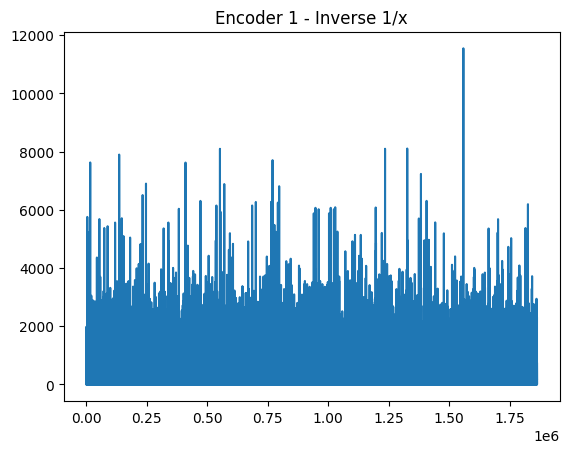

In [30]:
plt.title("Encoder 1 - Inverse 1/x")
plt.plot(input_inv_1)
print(min(input_inv_1))
print(max(input_inv_1))

-14.577587214831471
11.541062486215607


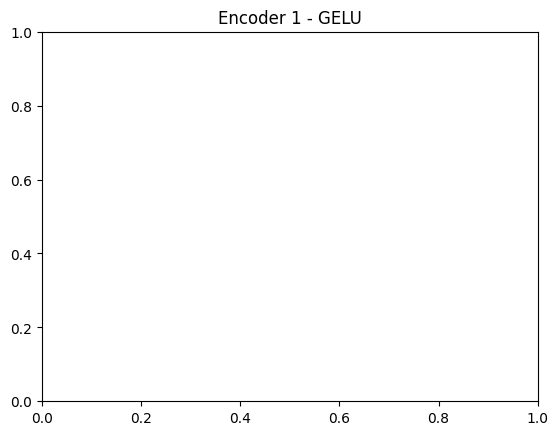

In [31]:
plt.title("Encoder 1 - GELU")
input_gelu_1 = np.array(input_gelu_1).reshape(-1)
#plt.plot(input_gelu_1)
print(min(input_gelu_1))
print(max(input_gelu_1))

0.1653476385500318
14442144.626600342


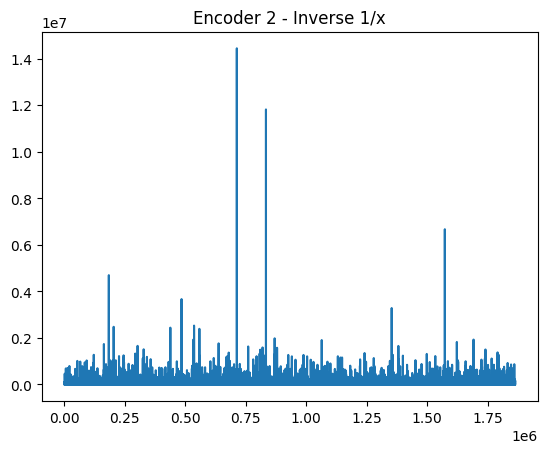

In [32]:
plt.title("Encoder 2 - Inverse 1/x")
plt.plot(input_inv_2)
print(min(input_inv_2))
print(max(input_inv_2))

-17.572206871443797
22.583263934433408


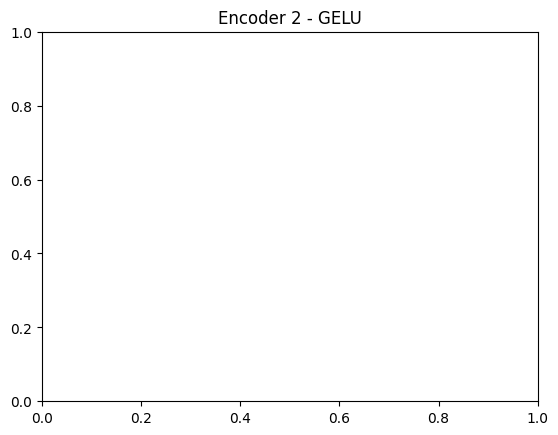

In [33]:
plt.title("Encoder 2 - GELU")
input_gelu_1 = np.array(input_gelu_2).reshape(-1)
print(min(input_gelu_2))
print(max(input_gelu_2))

-49.74612563409435
42.17698394528695


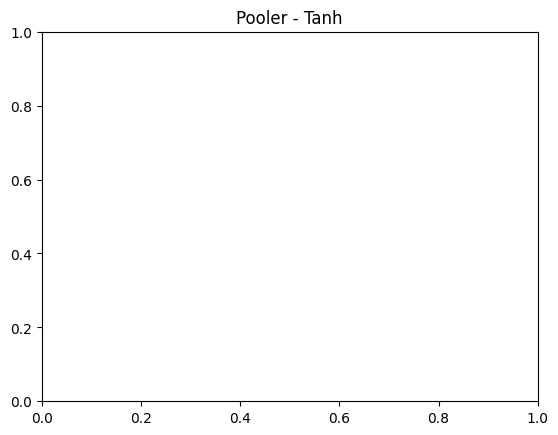

In [34]:
plt.title("Pooler - Tanh")
print(min(input_tanh))
print(max(input_tanh))

encoder 1
    1/x [1.34, 11546.02]
    gelu [-14.58, 11.54]
encoder 2
    1/x [0.17, 14442144.63]
    gelu [-17.57, 22.58]

    tanh [-49.75, 42.18]